In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams.update({'font.size': 16})

In [2]:
import numpy as np
import zarr
import matplotlib.pyplot as plt

In [3]:
import sys
import pathlib

package_path = pathlib.Path(".").resolve().parent.as_posix()
if package_path not in sys.path:
    sys.path.append(package_path)

In [4]:
from msi_zarr_analysis.utils.autocrop import autocrop
from msi_zarr_analysis.utils.iter_chunks import iter_loaded_chunks

### Dataset

In [5]:
r13 = zarr.open_group("../datasets/comulis13.zarr/")
r14 = zarr.open_group("../datasets/comulis14.zarr/")
r15 = zarr.open_group("../datasets/comulis15.zarr/")

r13_norm_2305 = zarr.open_group("../datasets/comulis13_norm_2305.zarr/")
r14_norm_2305 = zarr.open_group("../datasets/comulis14_norm_2305.zarr/")
r15_norm_2305 = zarr.open_group("../datasets/comulis15_norm_2305.zarr/")

r13_norm_max = zarr.open_group("../datasets/comulis13_norm_max.zarr/")
r14_norm_max = zarr.open_group("../datasets/comulis14_norm_max.zarr/")
r15_norm_max = zarr.open_group("../datasets/comulis15_norm_max.zarr/")

#### Padding

In [6]:
def show_padding(z_group, name: str, figsize):
    n_arr = z_group["/labels/lengths/0"][0, 0]
    n_arr = n_arr > 0
    
    plt.figure(figsize=figsize)
    plt.imshow(n_arr, interpolation="nearest")
    plt.title("Presence of spectra in " + name)

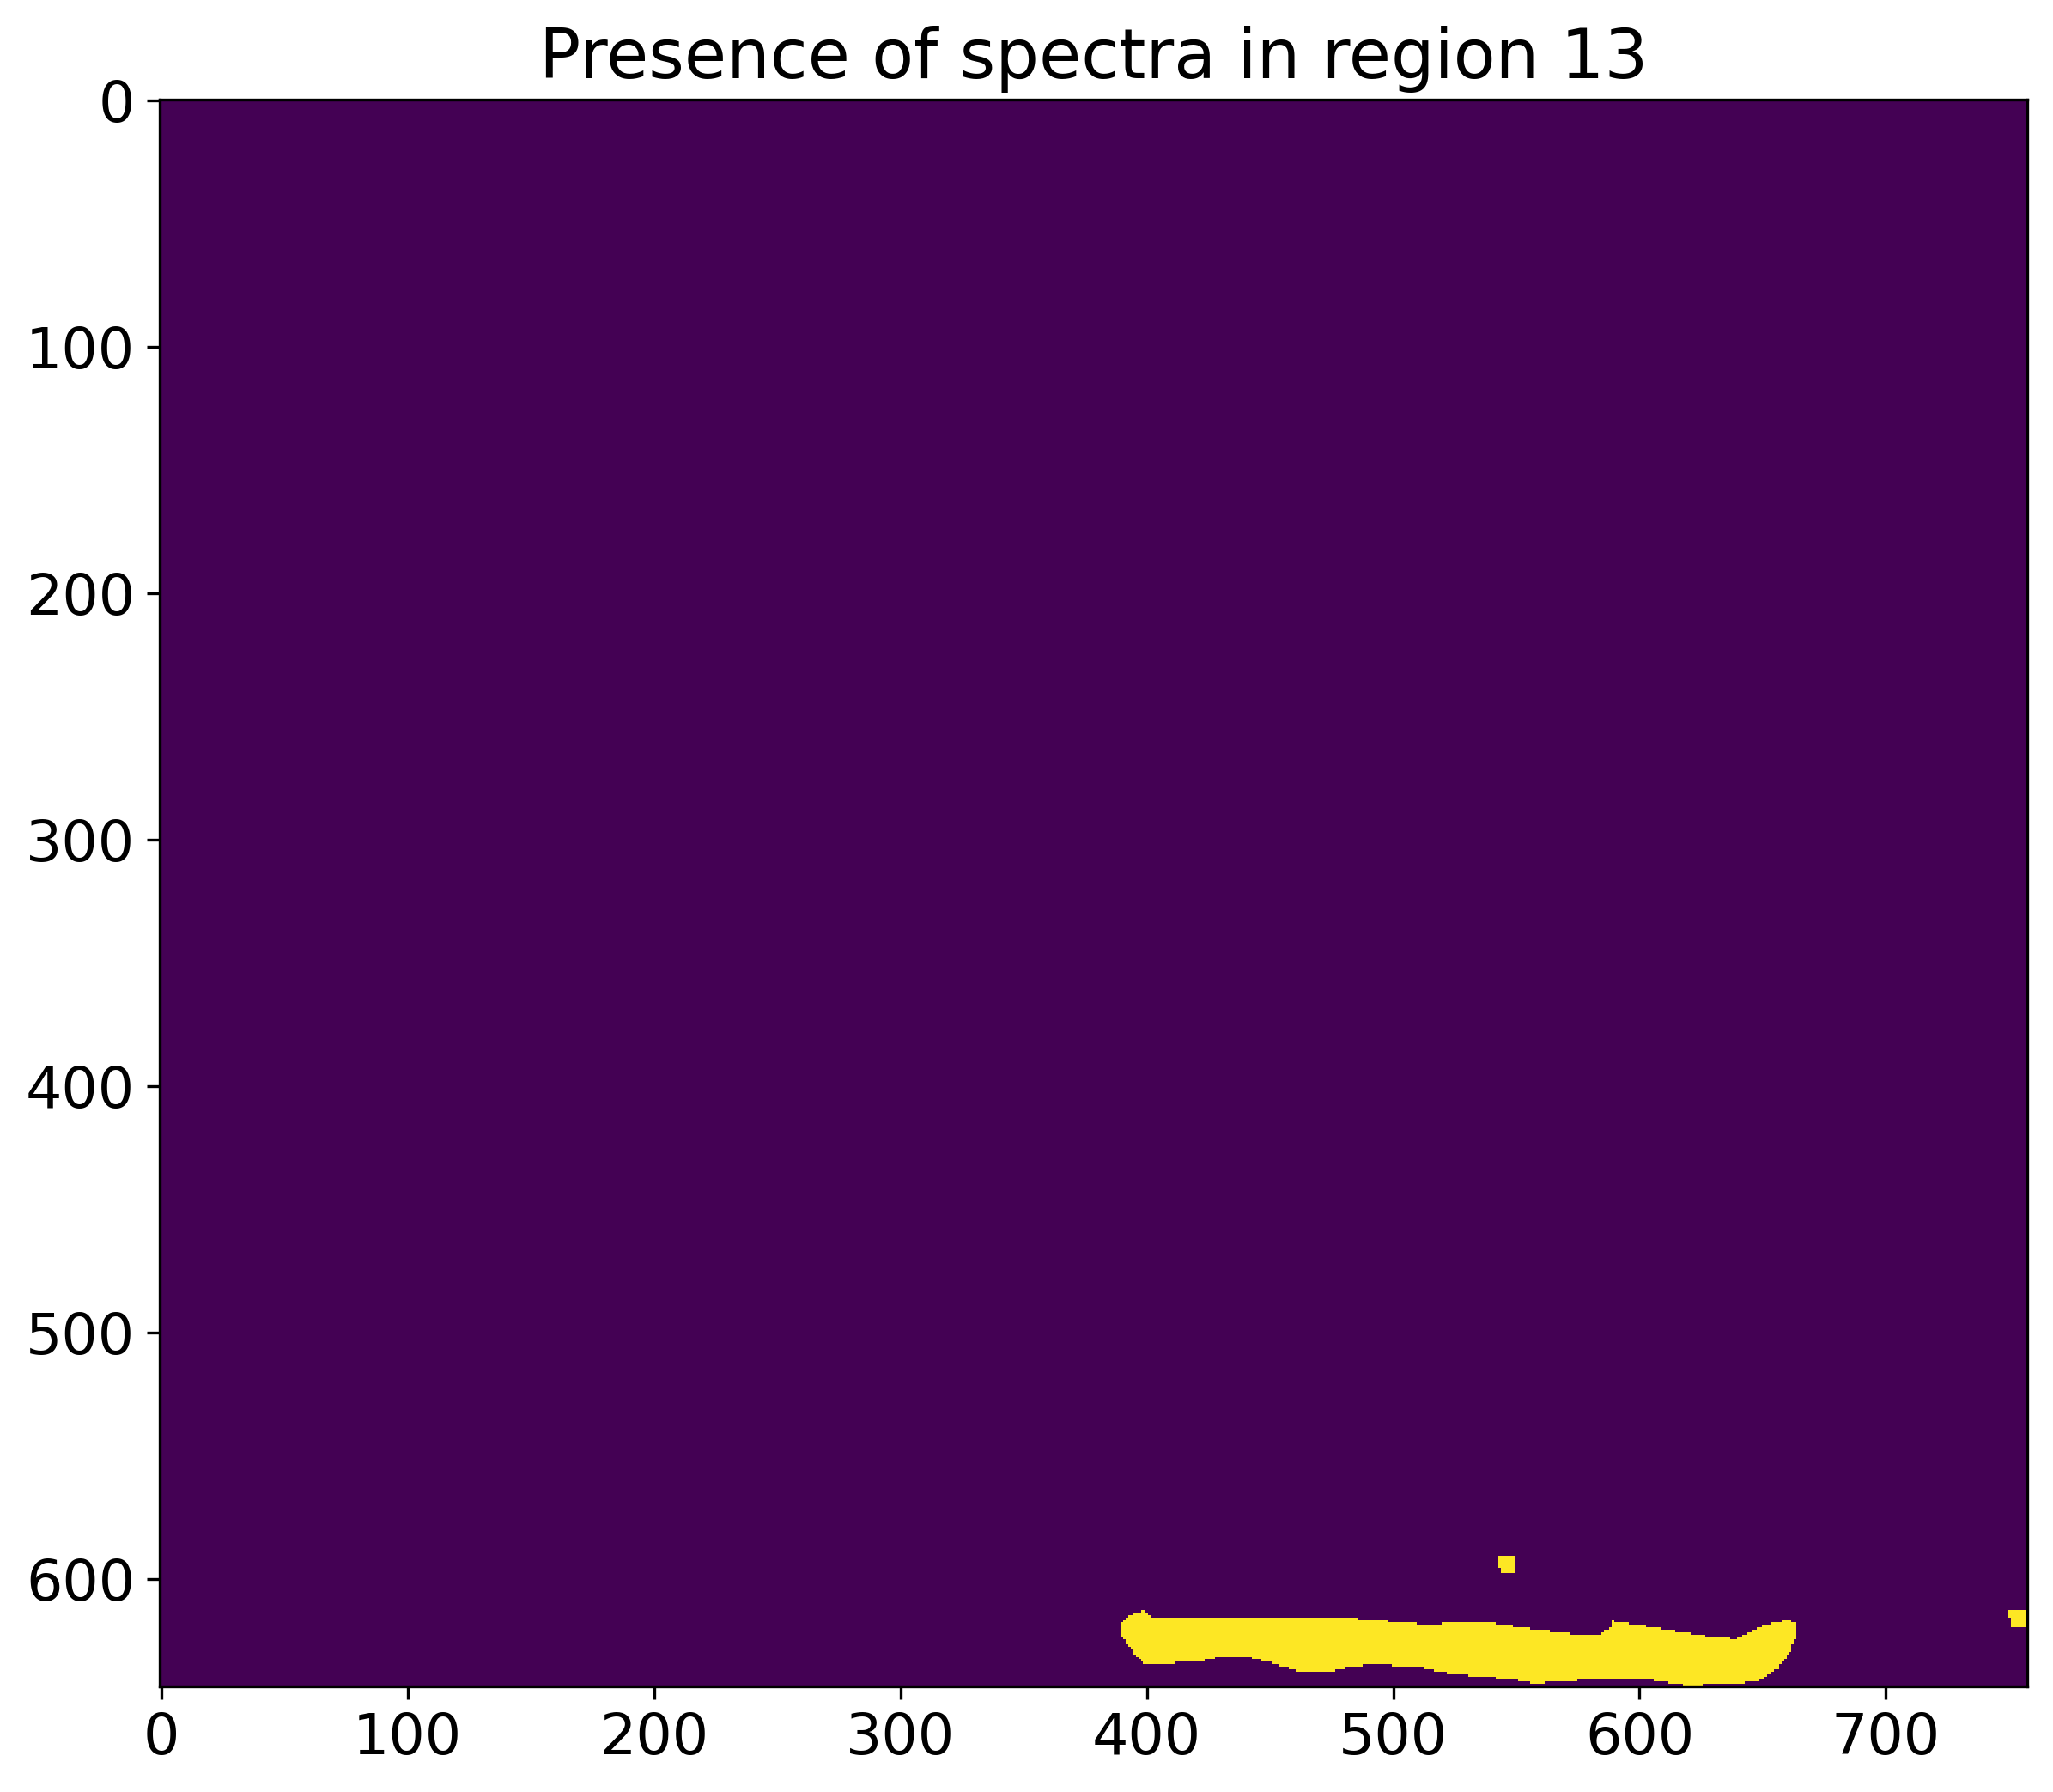

In [7]:
show_padding(r13, "region 13", figsize=(25, 8))

#### Lengths of the spectra

In [8]:
def plot_lens(z_group, name: str, figsize):
    n_arr = z_group["/labels/lengths/0"][0, 0]
    bounds = autocrop(n_arr)
    
    n_arr = np.where(n_arr > 0, n_arr, np.nan)

    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap().copy()
    cmap.set_bad(color='black')
    plt.imshow(n_arr[bounds], interpolation="nearest", cmap=cmap)
    plt.title("Length of spectra for " + name)
    plt.colorbar()

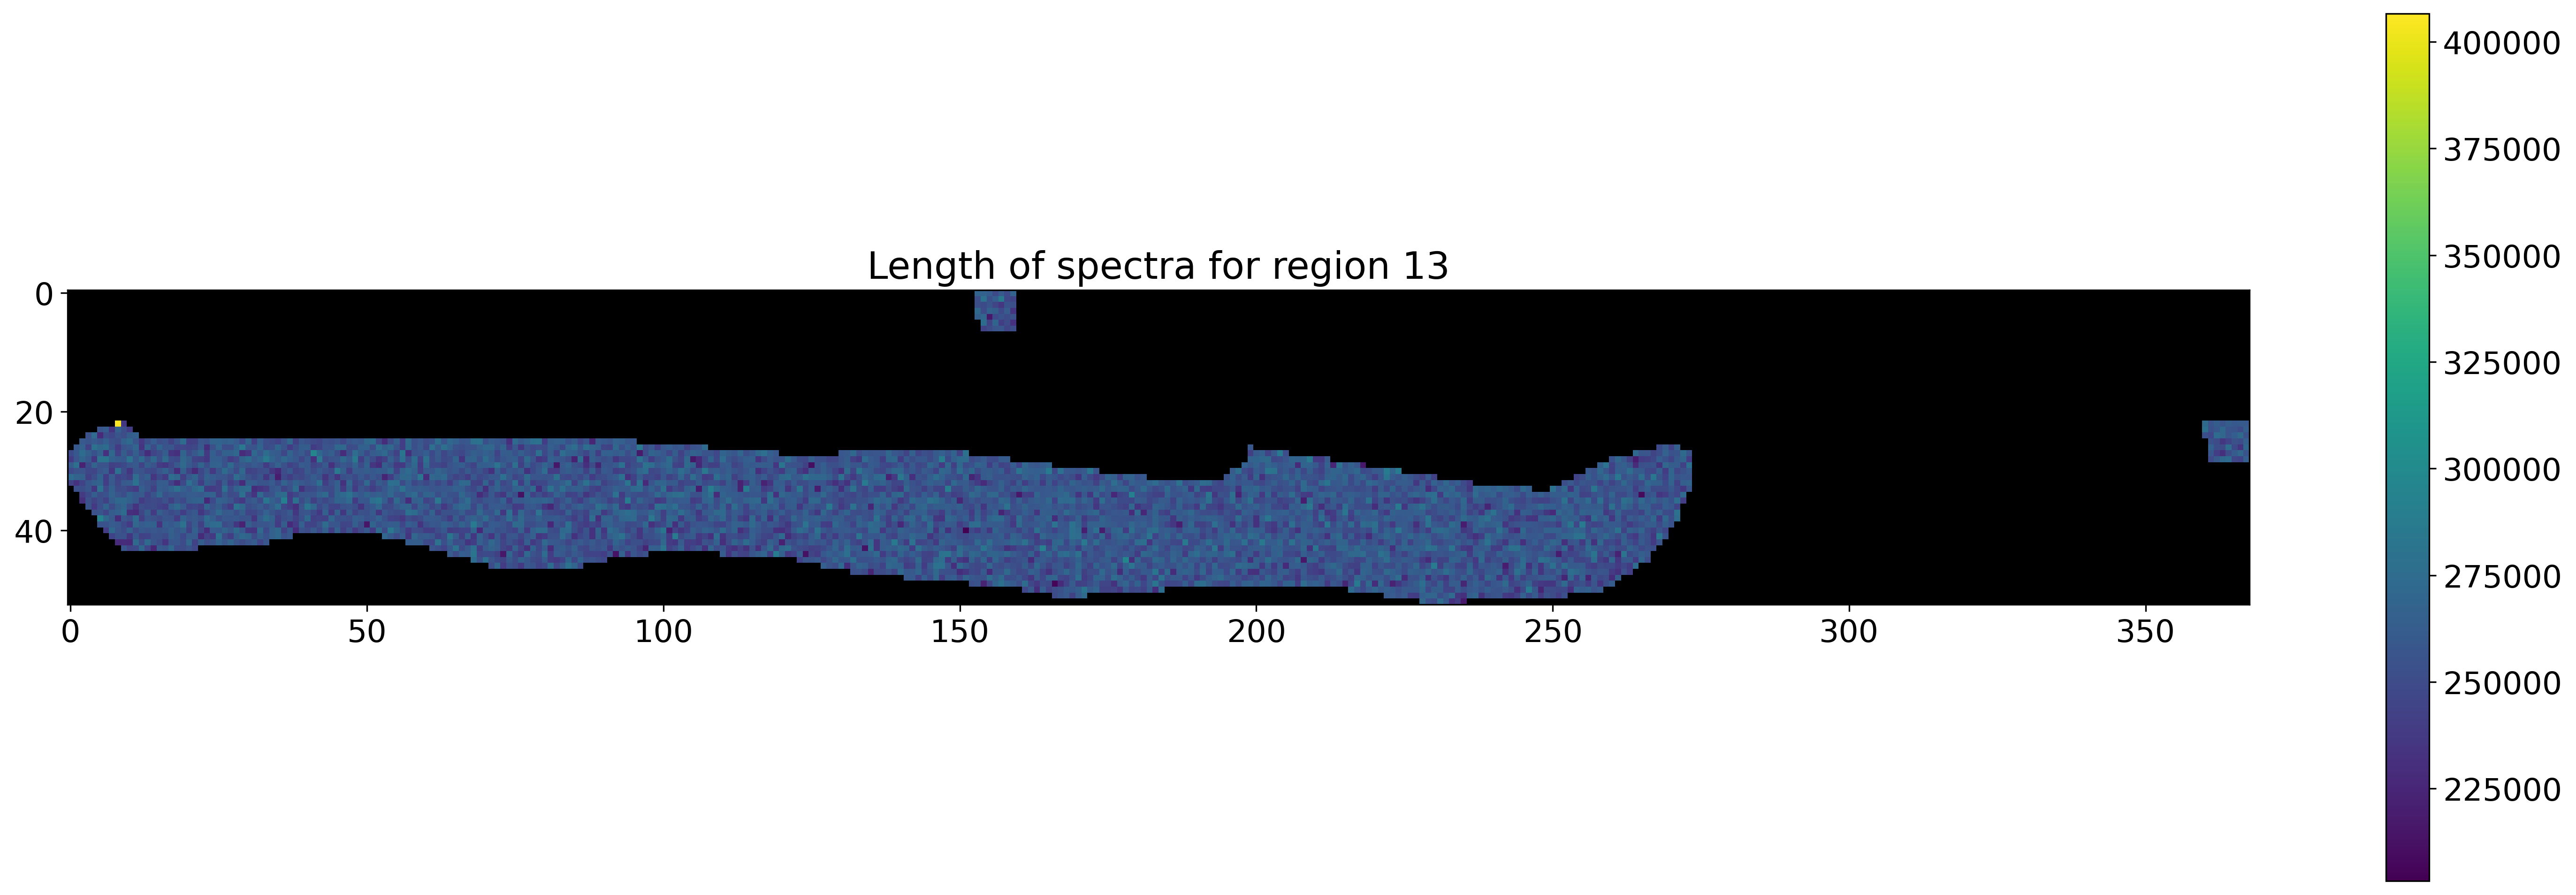

In [9]:
plot_lens(r13, "region 13", figsize=(25, 8))

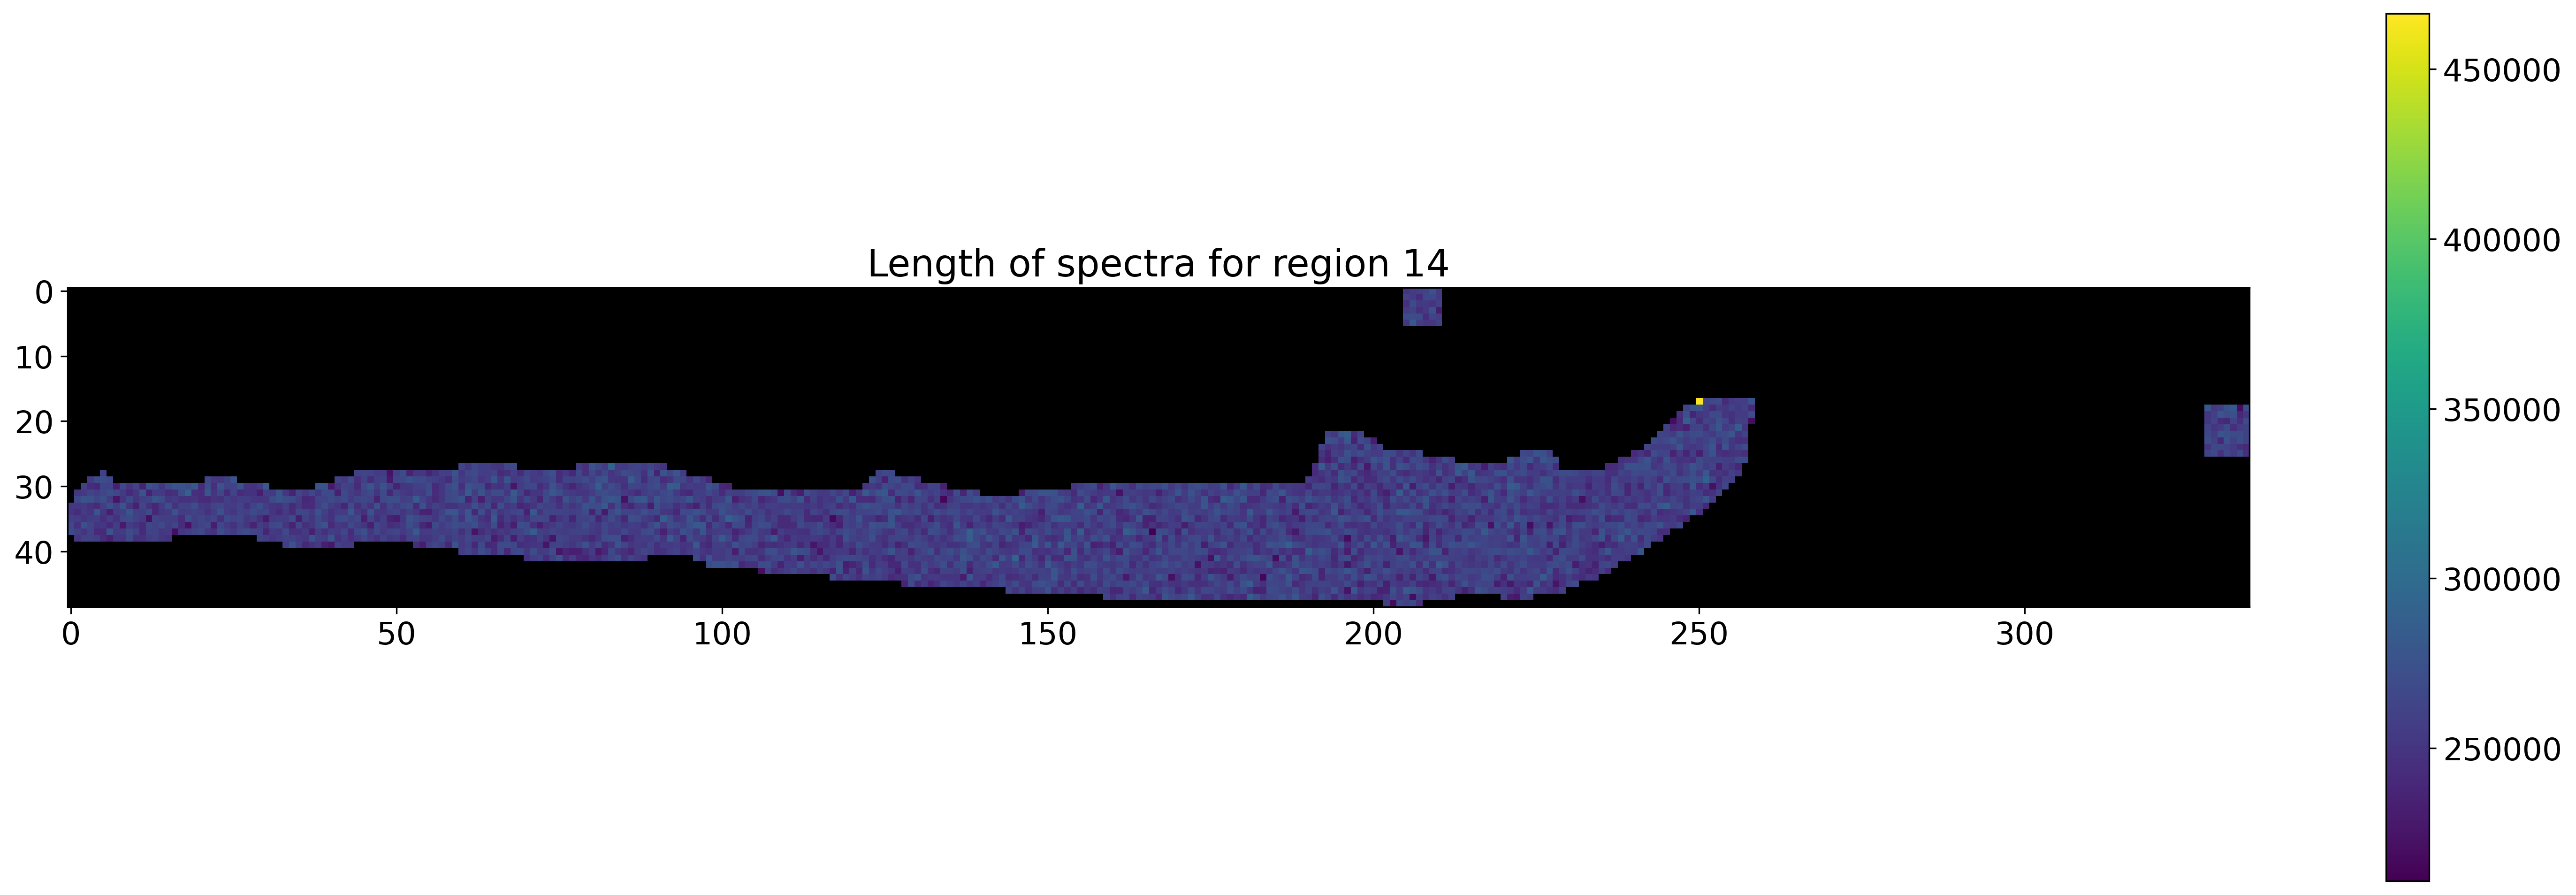

In [10]:
plot_lens(r14, "region 14", figsize=(25, 8))

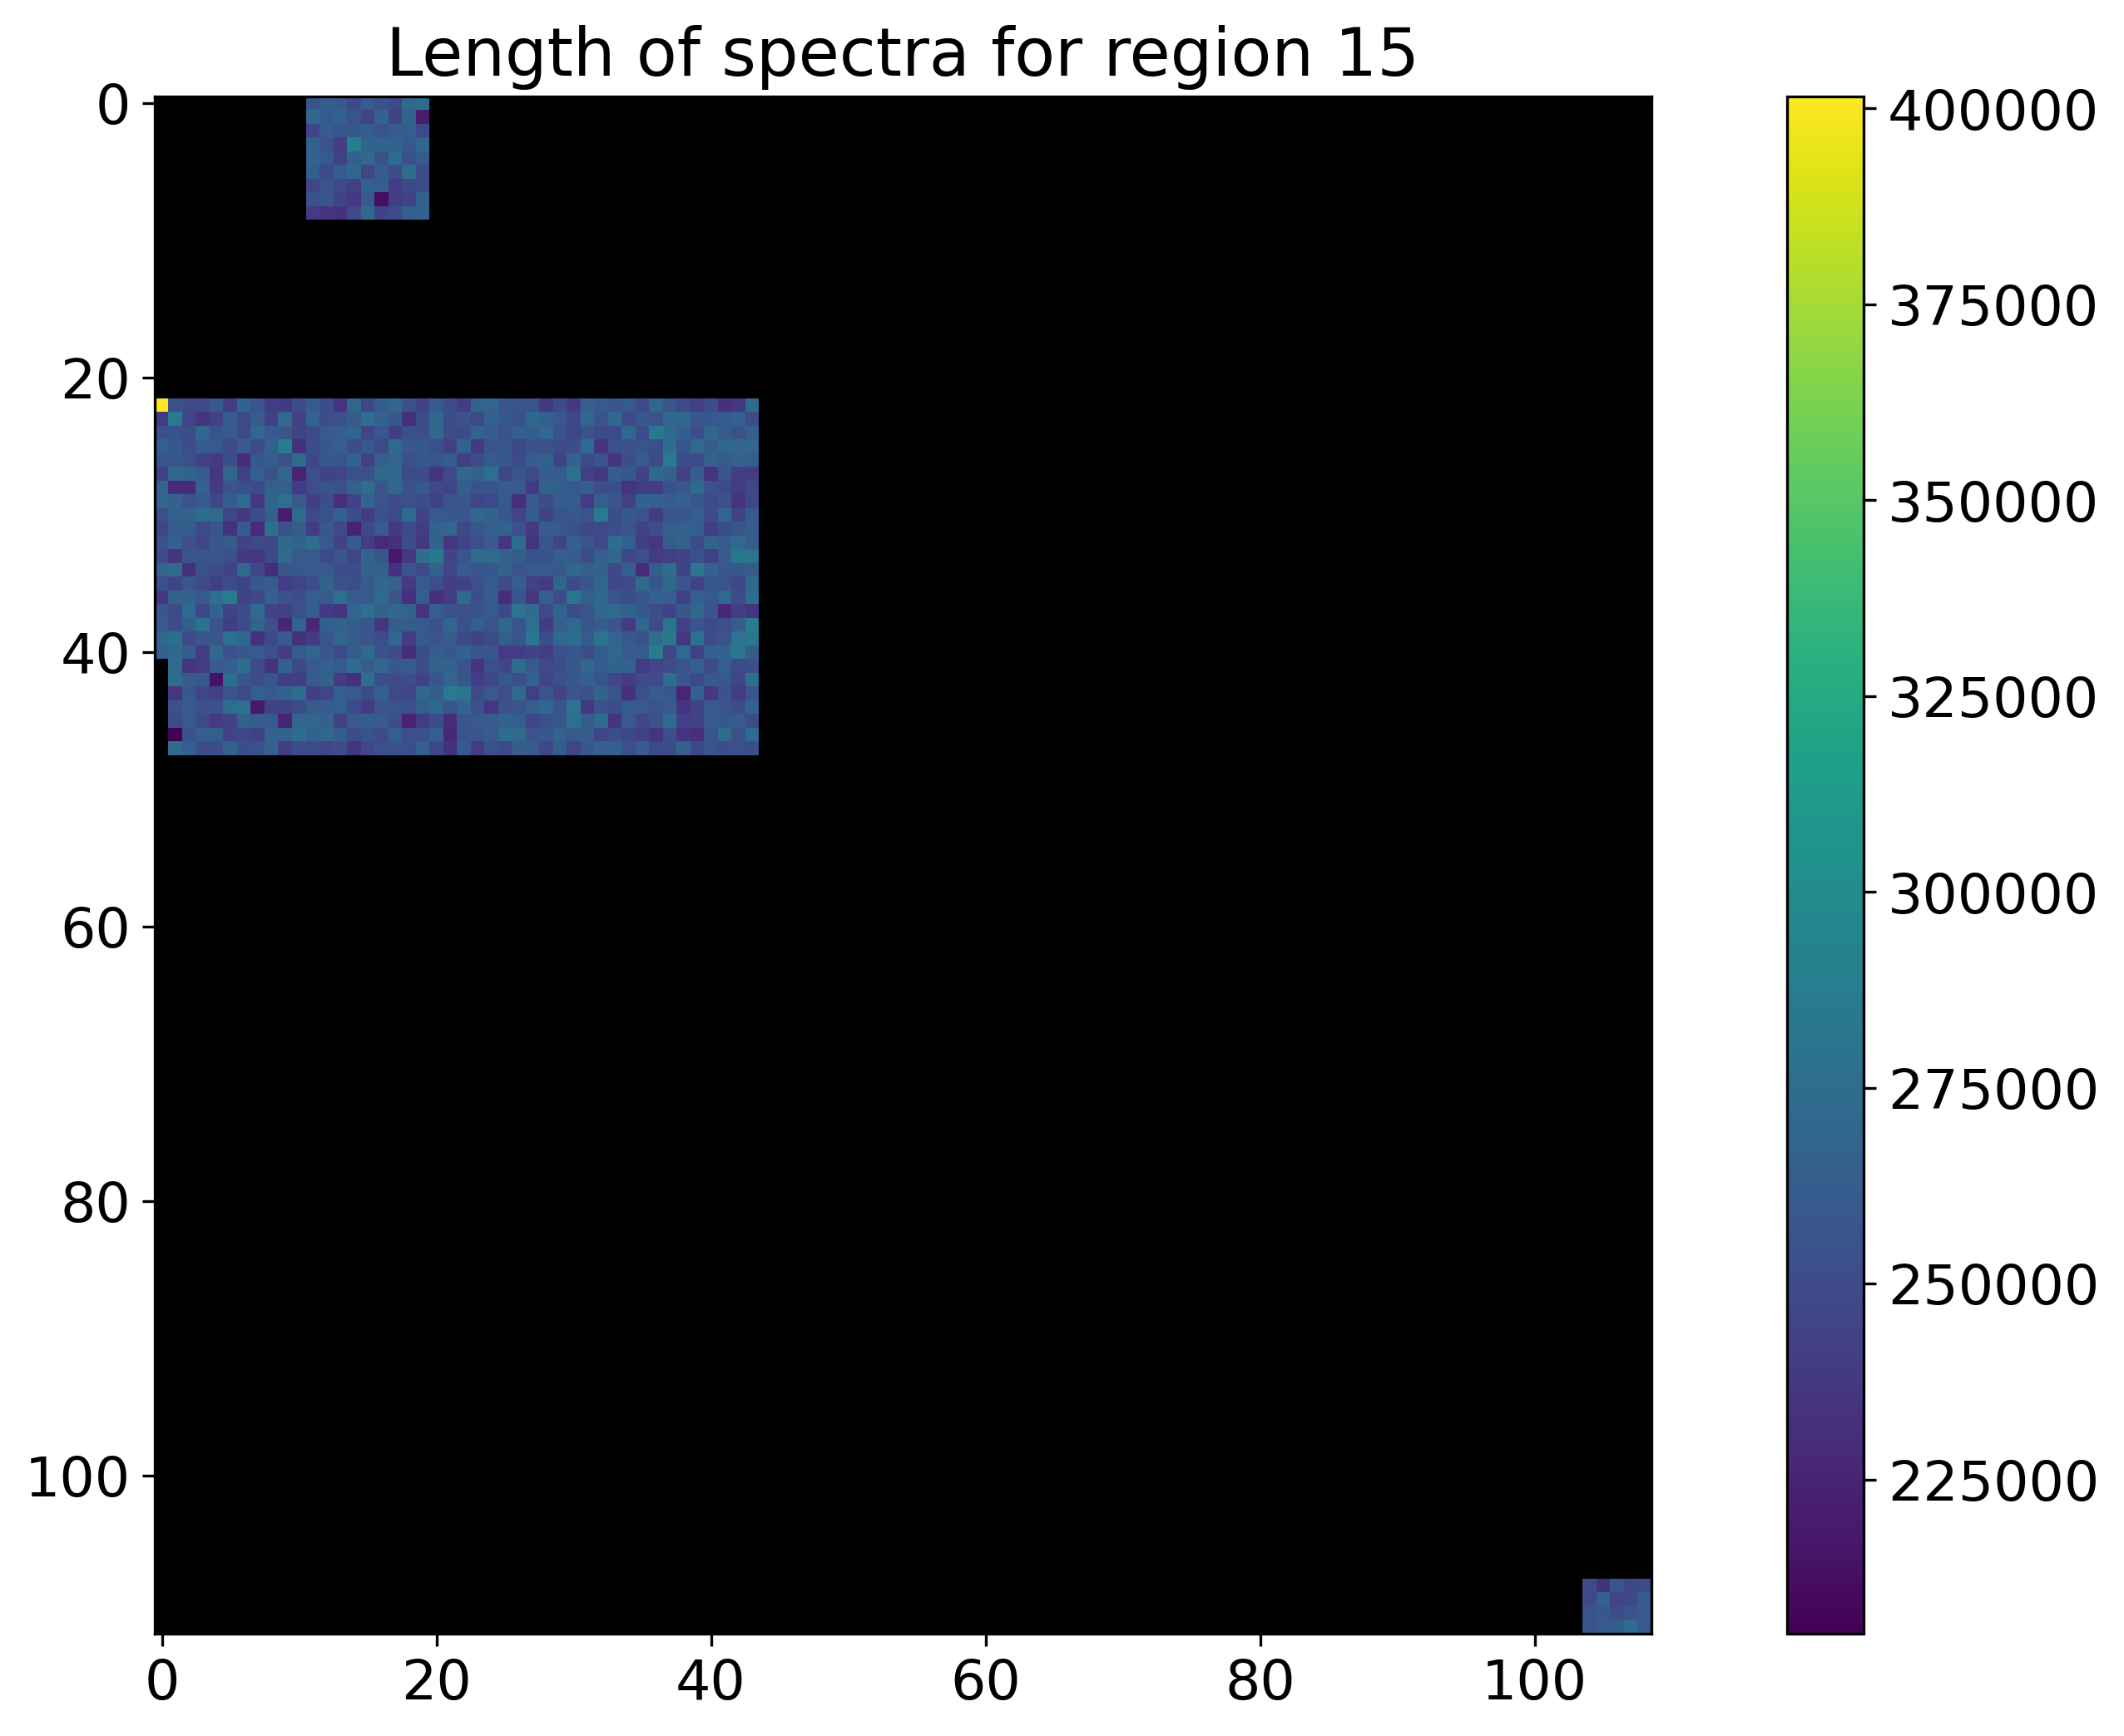

In [11]:
plot_lens(r15, "region 15", figsize=(14, 8))

### Normalization at m/z=317.176

In [12]:
def show_normalization(
    n_spectra: int,
    *,
    figsize: tuple,
    **z_group_dict,
) -> None:
    assert len(z_group_dict) > 0, "needs at least one dataset"

    lo, hi = 305, 330

    fig, axes = plt.subplots(
        nrows=len(z_group_dict),
        ncols=n_spectra,
        figsize=figsize,
        sharex=False,  # actually share the axis, but repeating the ticks is prettier
        squeeze=False,
    )
    
    fig.suptitle("Normalization at m/z=317.176")

    for ds_idx, (label, z_group) in enumerate(z_group_dict.items()):
        n_len = z_group["/labels/lengths/0"][0, 0]
        idxs = np.nonzero(n_len)
        selection = np.random.randint(idxs[0].size, size=(n_spectra,))
        
        for point_idx, (y, x) in enumerate(zip(idxs[0][selection], idxs[1][selection])):
            s_len = n_len[y, x]  # they should all have the same lenght, not the case
            s_mzs = z_group["/labels/mzs/0"][:s_len, 0, y, x]
            s_int = z_group["/0"][:s_len, 0, y, x]
            
            ax = axes[ds_idx, point_idx]
            ax.set_title(label + f" {y=}, {x=}")
            sub_range = slice(
                np.searchsorted(s_mzs, lo, side="left"),
                np.searchsorted(s_mzs, hi, side="right"),
            )
            
            s_mzs = s_mzs[sub_range]
            s_int = s_int[sub_range]
            
            ax.stem(s_mzs, s_int, basefmt="none", linefmt="C0-", markerfmt=",")
            #print(f"{i=} {j=}, {s_len=}")
            
            # re-stem the close ones to 1.0
            close_mask = np.abs(s_int - 1.0) < 0.05
            if np.count_nonzero(close_mask) > 1:
                ax.stem(s_mzs[close_mask], s_int[close_mask], basefmt="none", linefmt="none", markerfmt="C3x")
            elif np.count_nonzero(close_mask) == 1:
                ax.stem((s_mzs[close_mask],), (s_int[close_mask],), basefmt="none", linefmt="none", markerfmt="C3x")
            
            ax.stem((317.176,), (0,), basefmt="none", markerfmt="^")
    
            ax.set_ylim((-0.05, 1.2))
    
    fig.tight_layout()

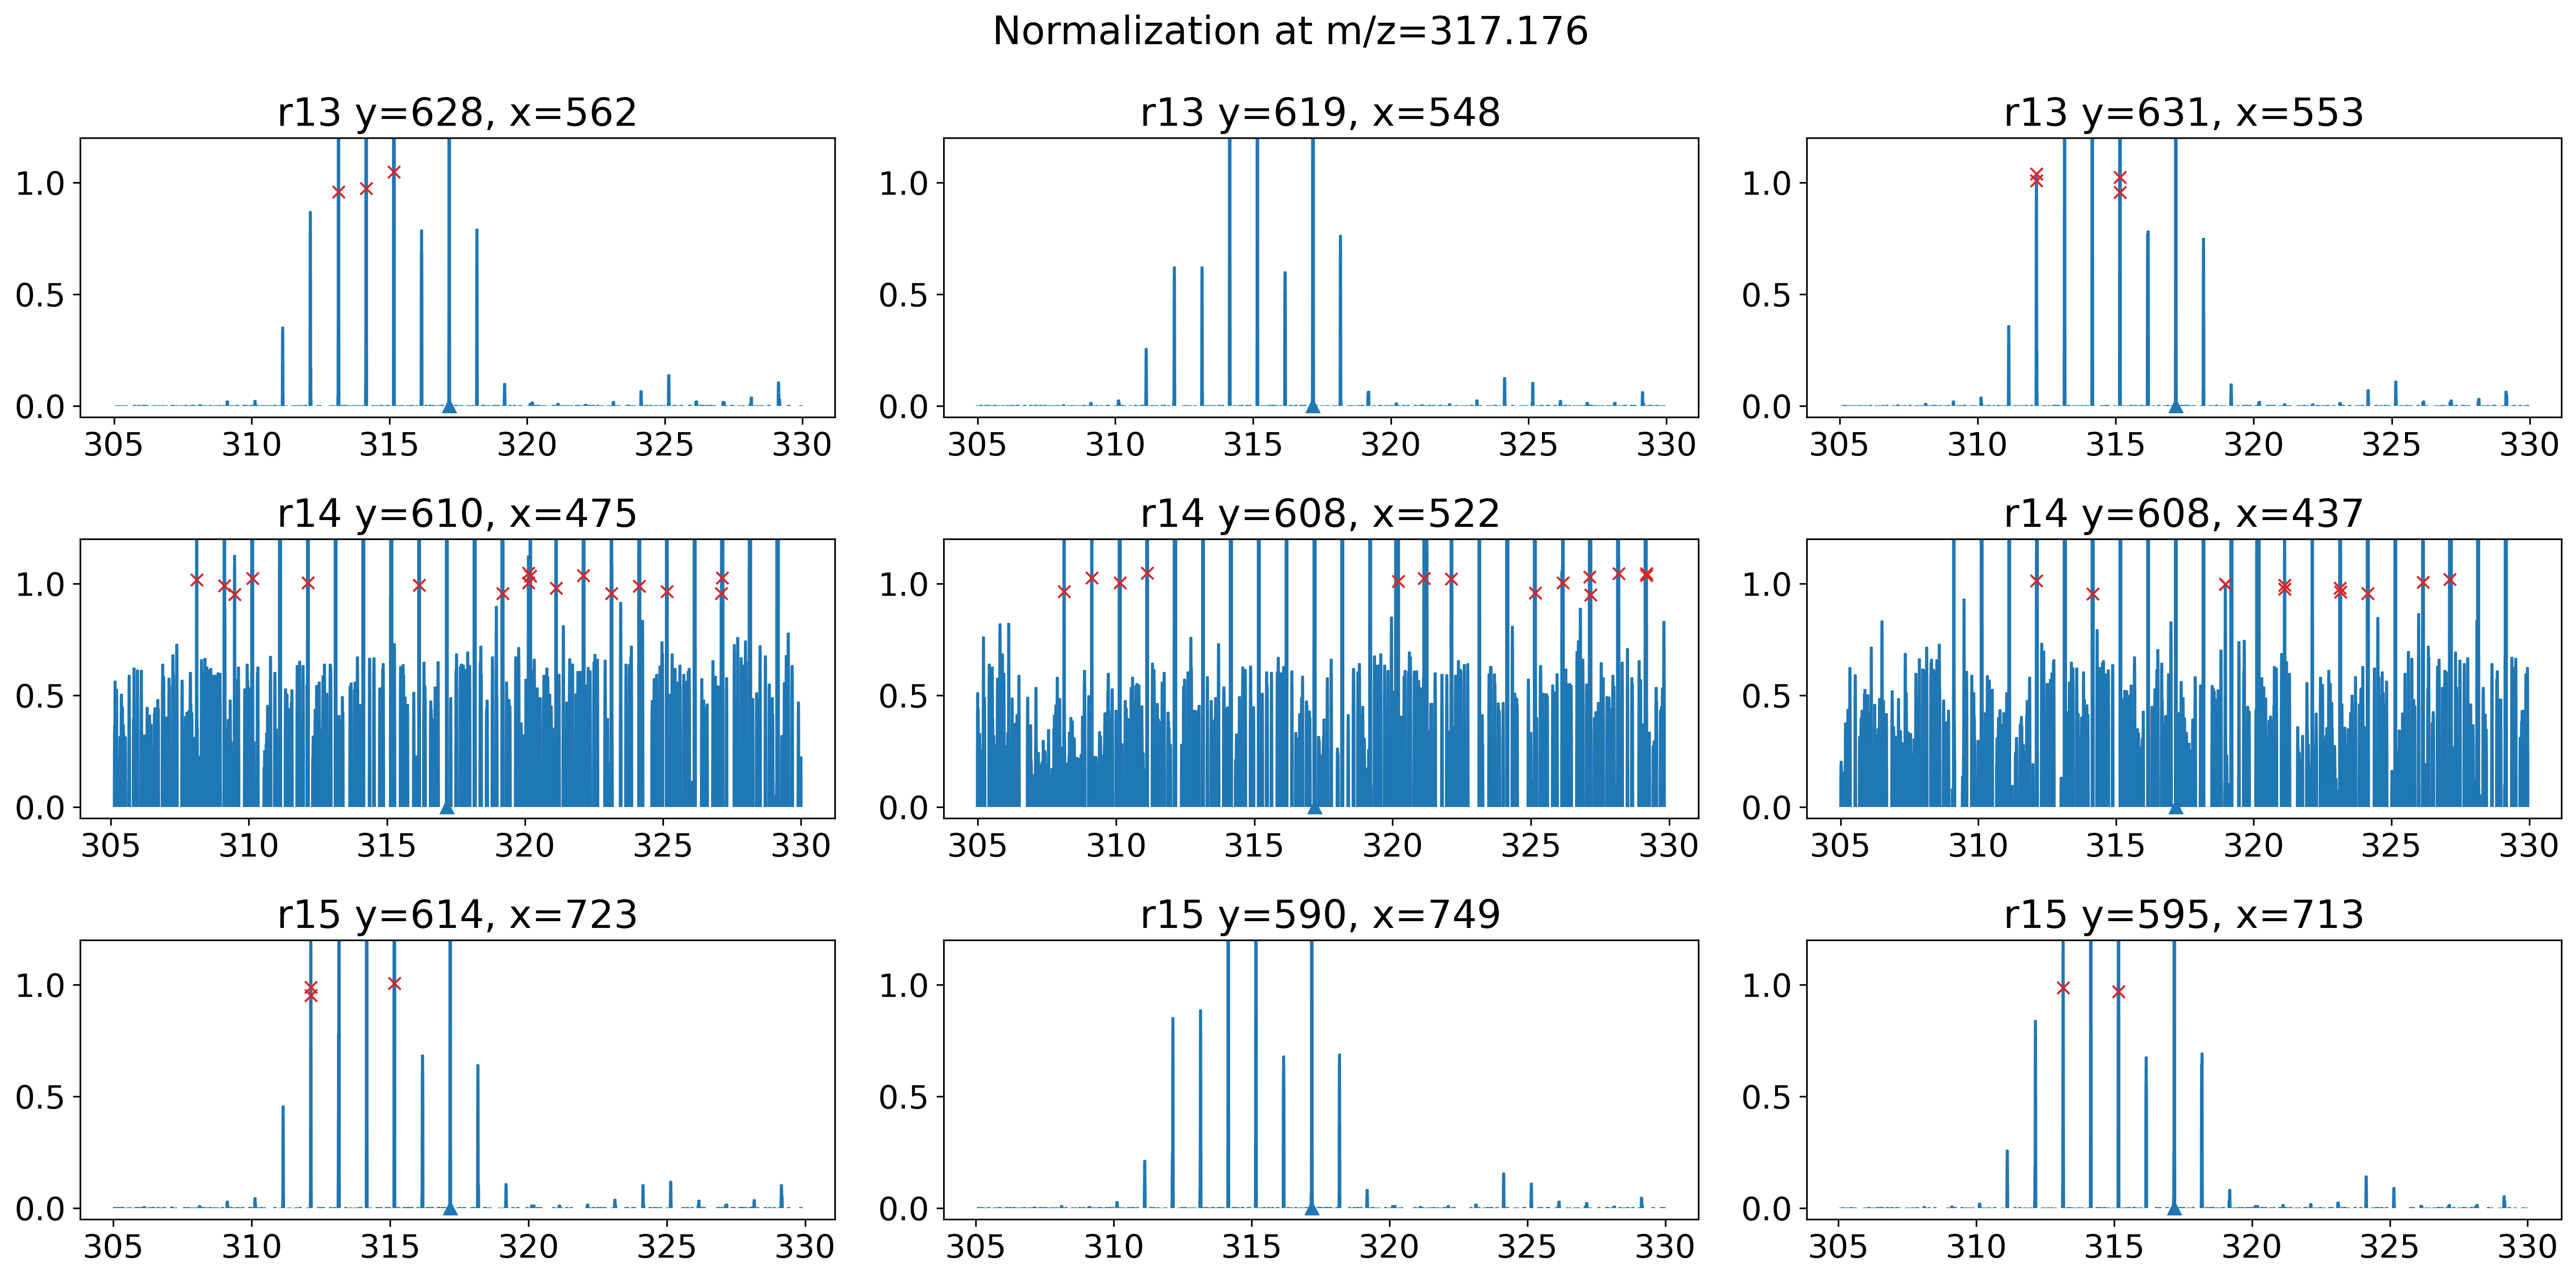

In [13]:
show_normalization(3, figsize=(18, 9), r13=r13_norm_2305, r14=r14_norm_2305, r15=r15_norm_2305)

#### Different lengths

In [14]:
def compare_lens(name_left, z_group_left, name_right, z_group_right, figsize):
    n_arr_left = z_group_left["/labels/lengths/0"][0, 0]
    n_arr_right = z_group_right["/labels/lengths/0"][0, 0]
    
    assert n_arr_left.shape == n_arr_right.shape, "shape mismatch"

    bounds = autocrop(n_arr_left | n_arr_right)
    
    diff = n_arr_left - n_arr_right
    diff = np.where((n_arr_left | n_arr_right) > 0, diff, np.nan)

    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap().copy()
    cmap.set_bad(color='#DDDDDD')
    plt.imshow(diff[bounds], interpolation="nearest", cmap=cmap)
    plt.title(f"{name_left} / {name_right}")
    plt.colorbar()

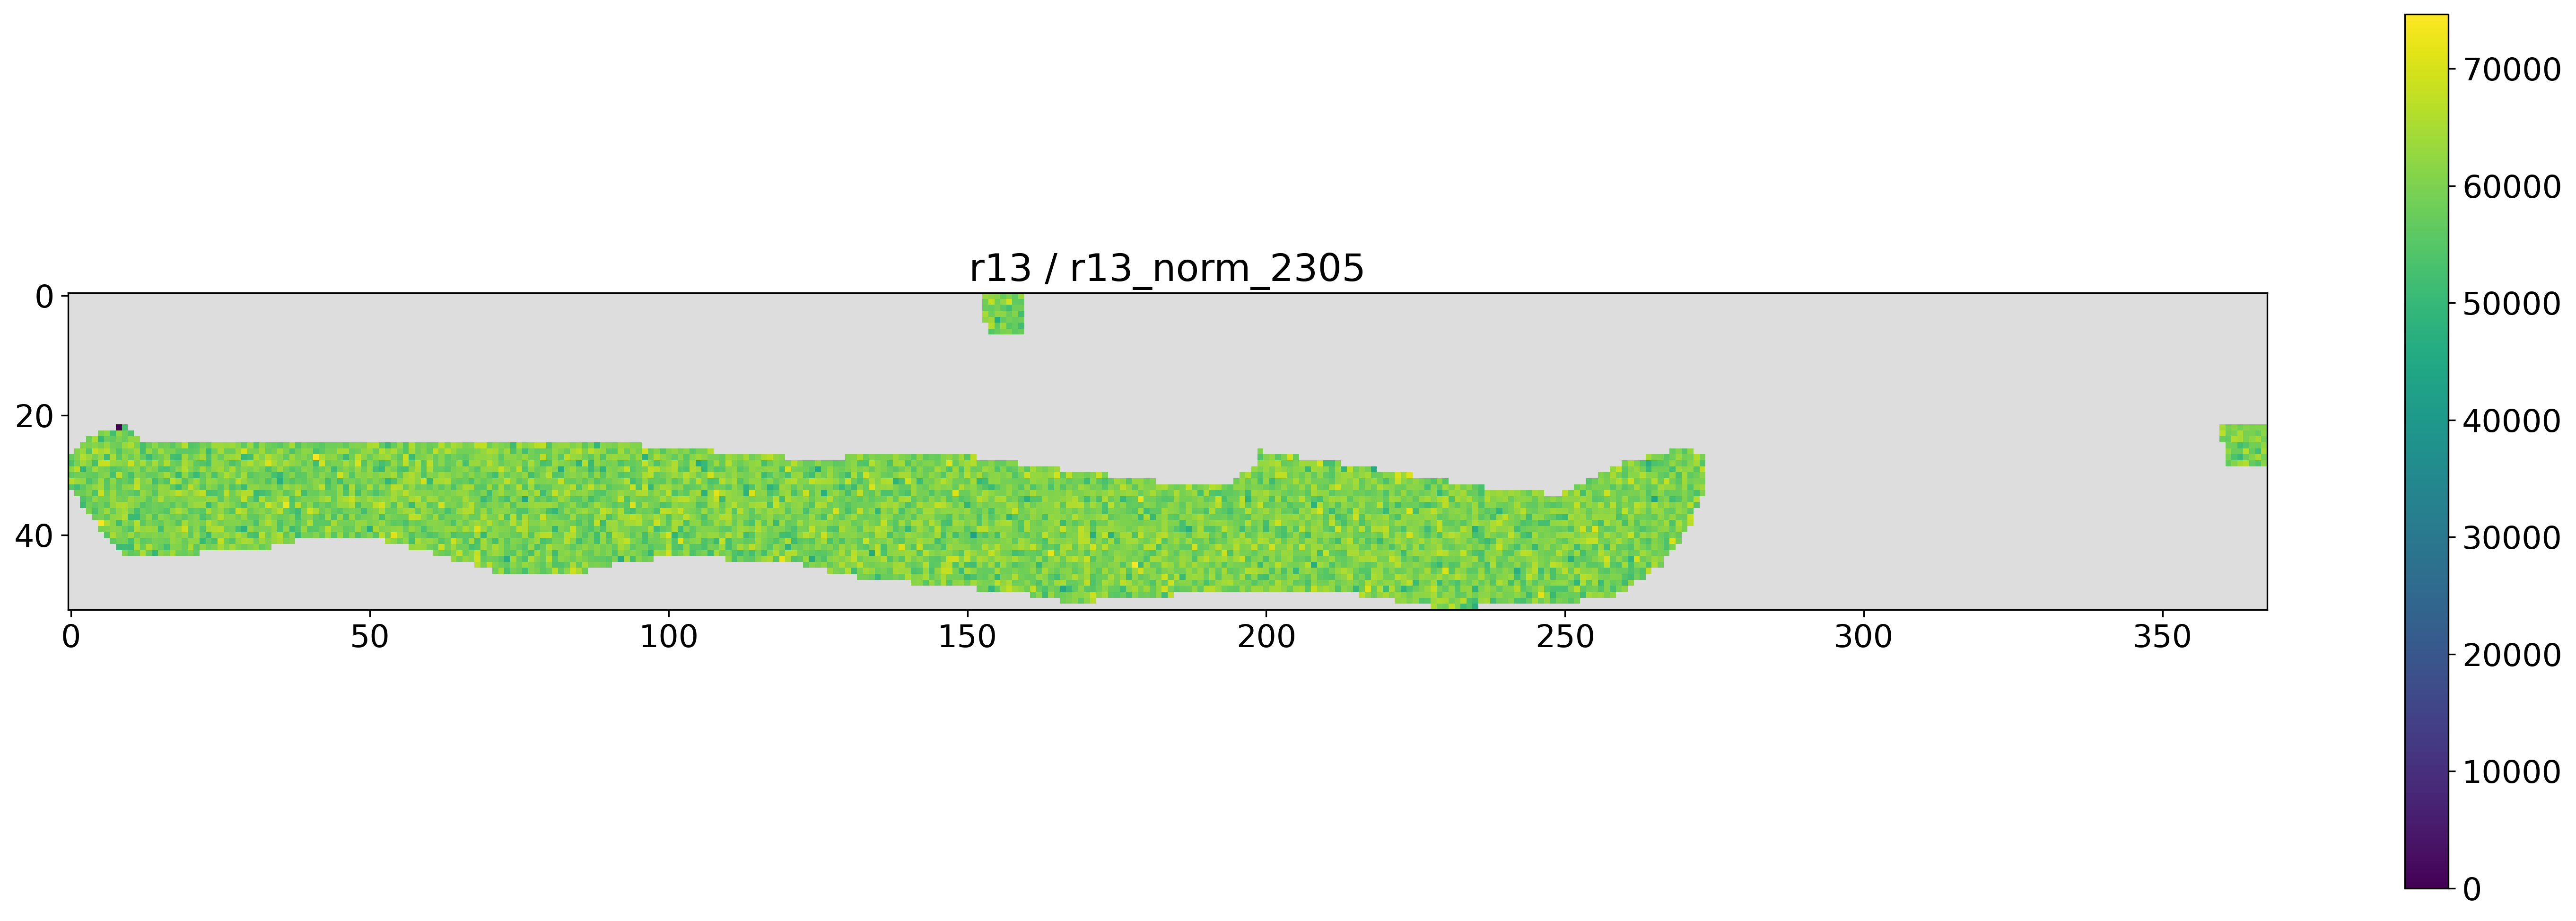

In [15]:
compare_lens("r13", r13, "r13_norm_2305", r13_norm_2305, figsize=(25, 8))

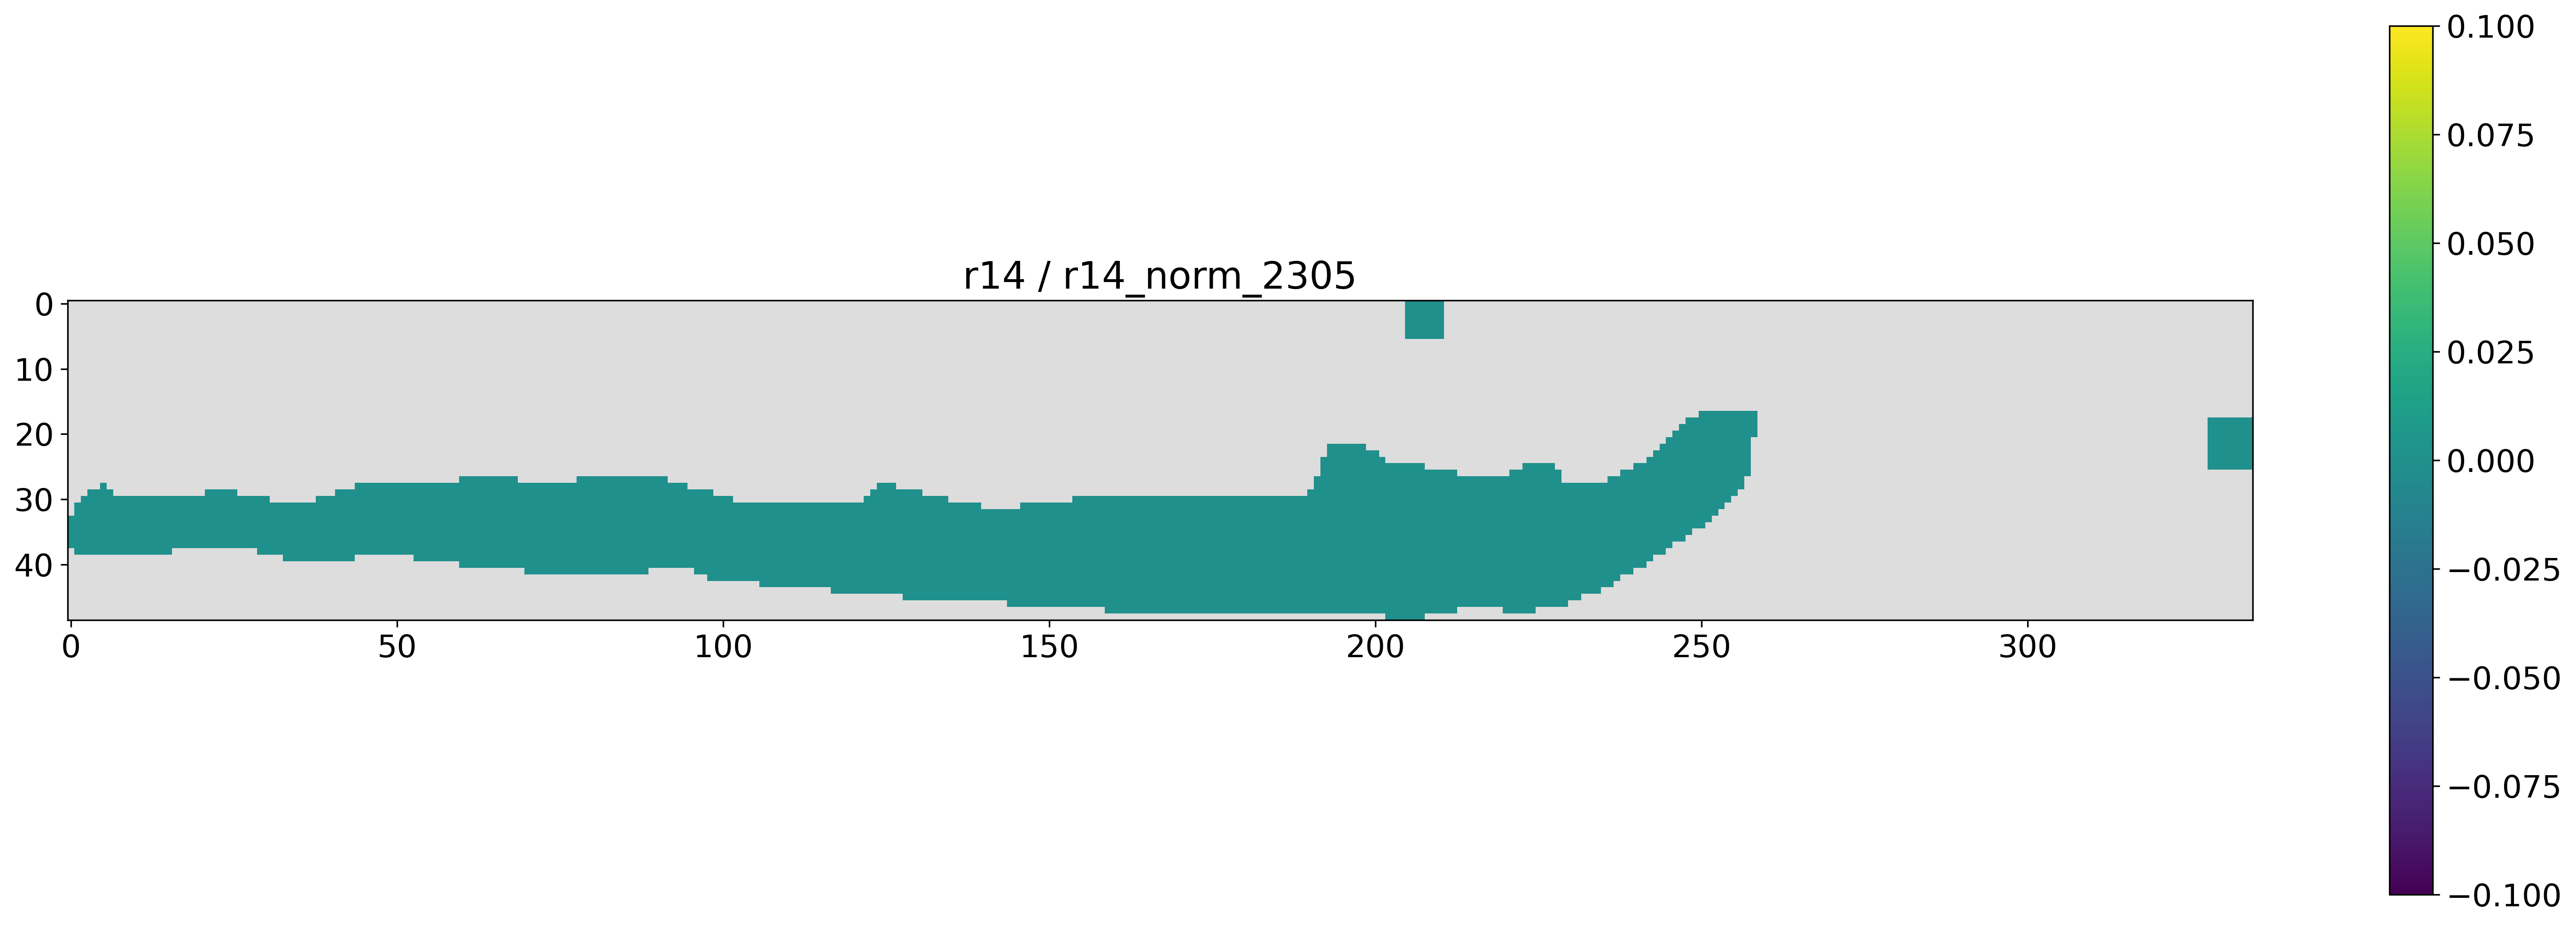

In [16]:
compare_lens("r14", r14, "r14_norm_2305", r14_norm_2305, figsize=(25, 8))

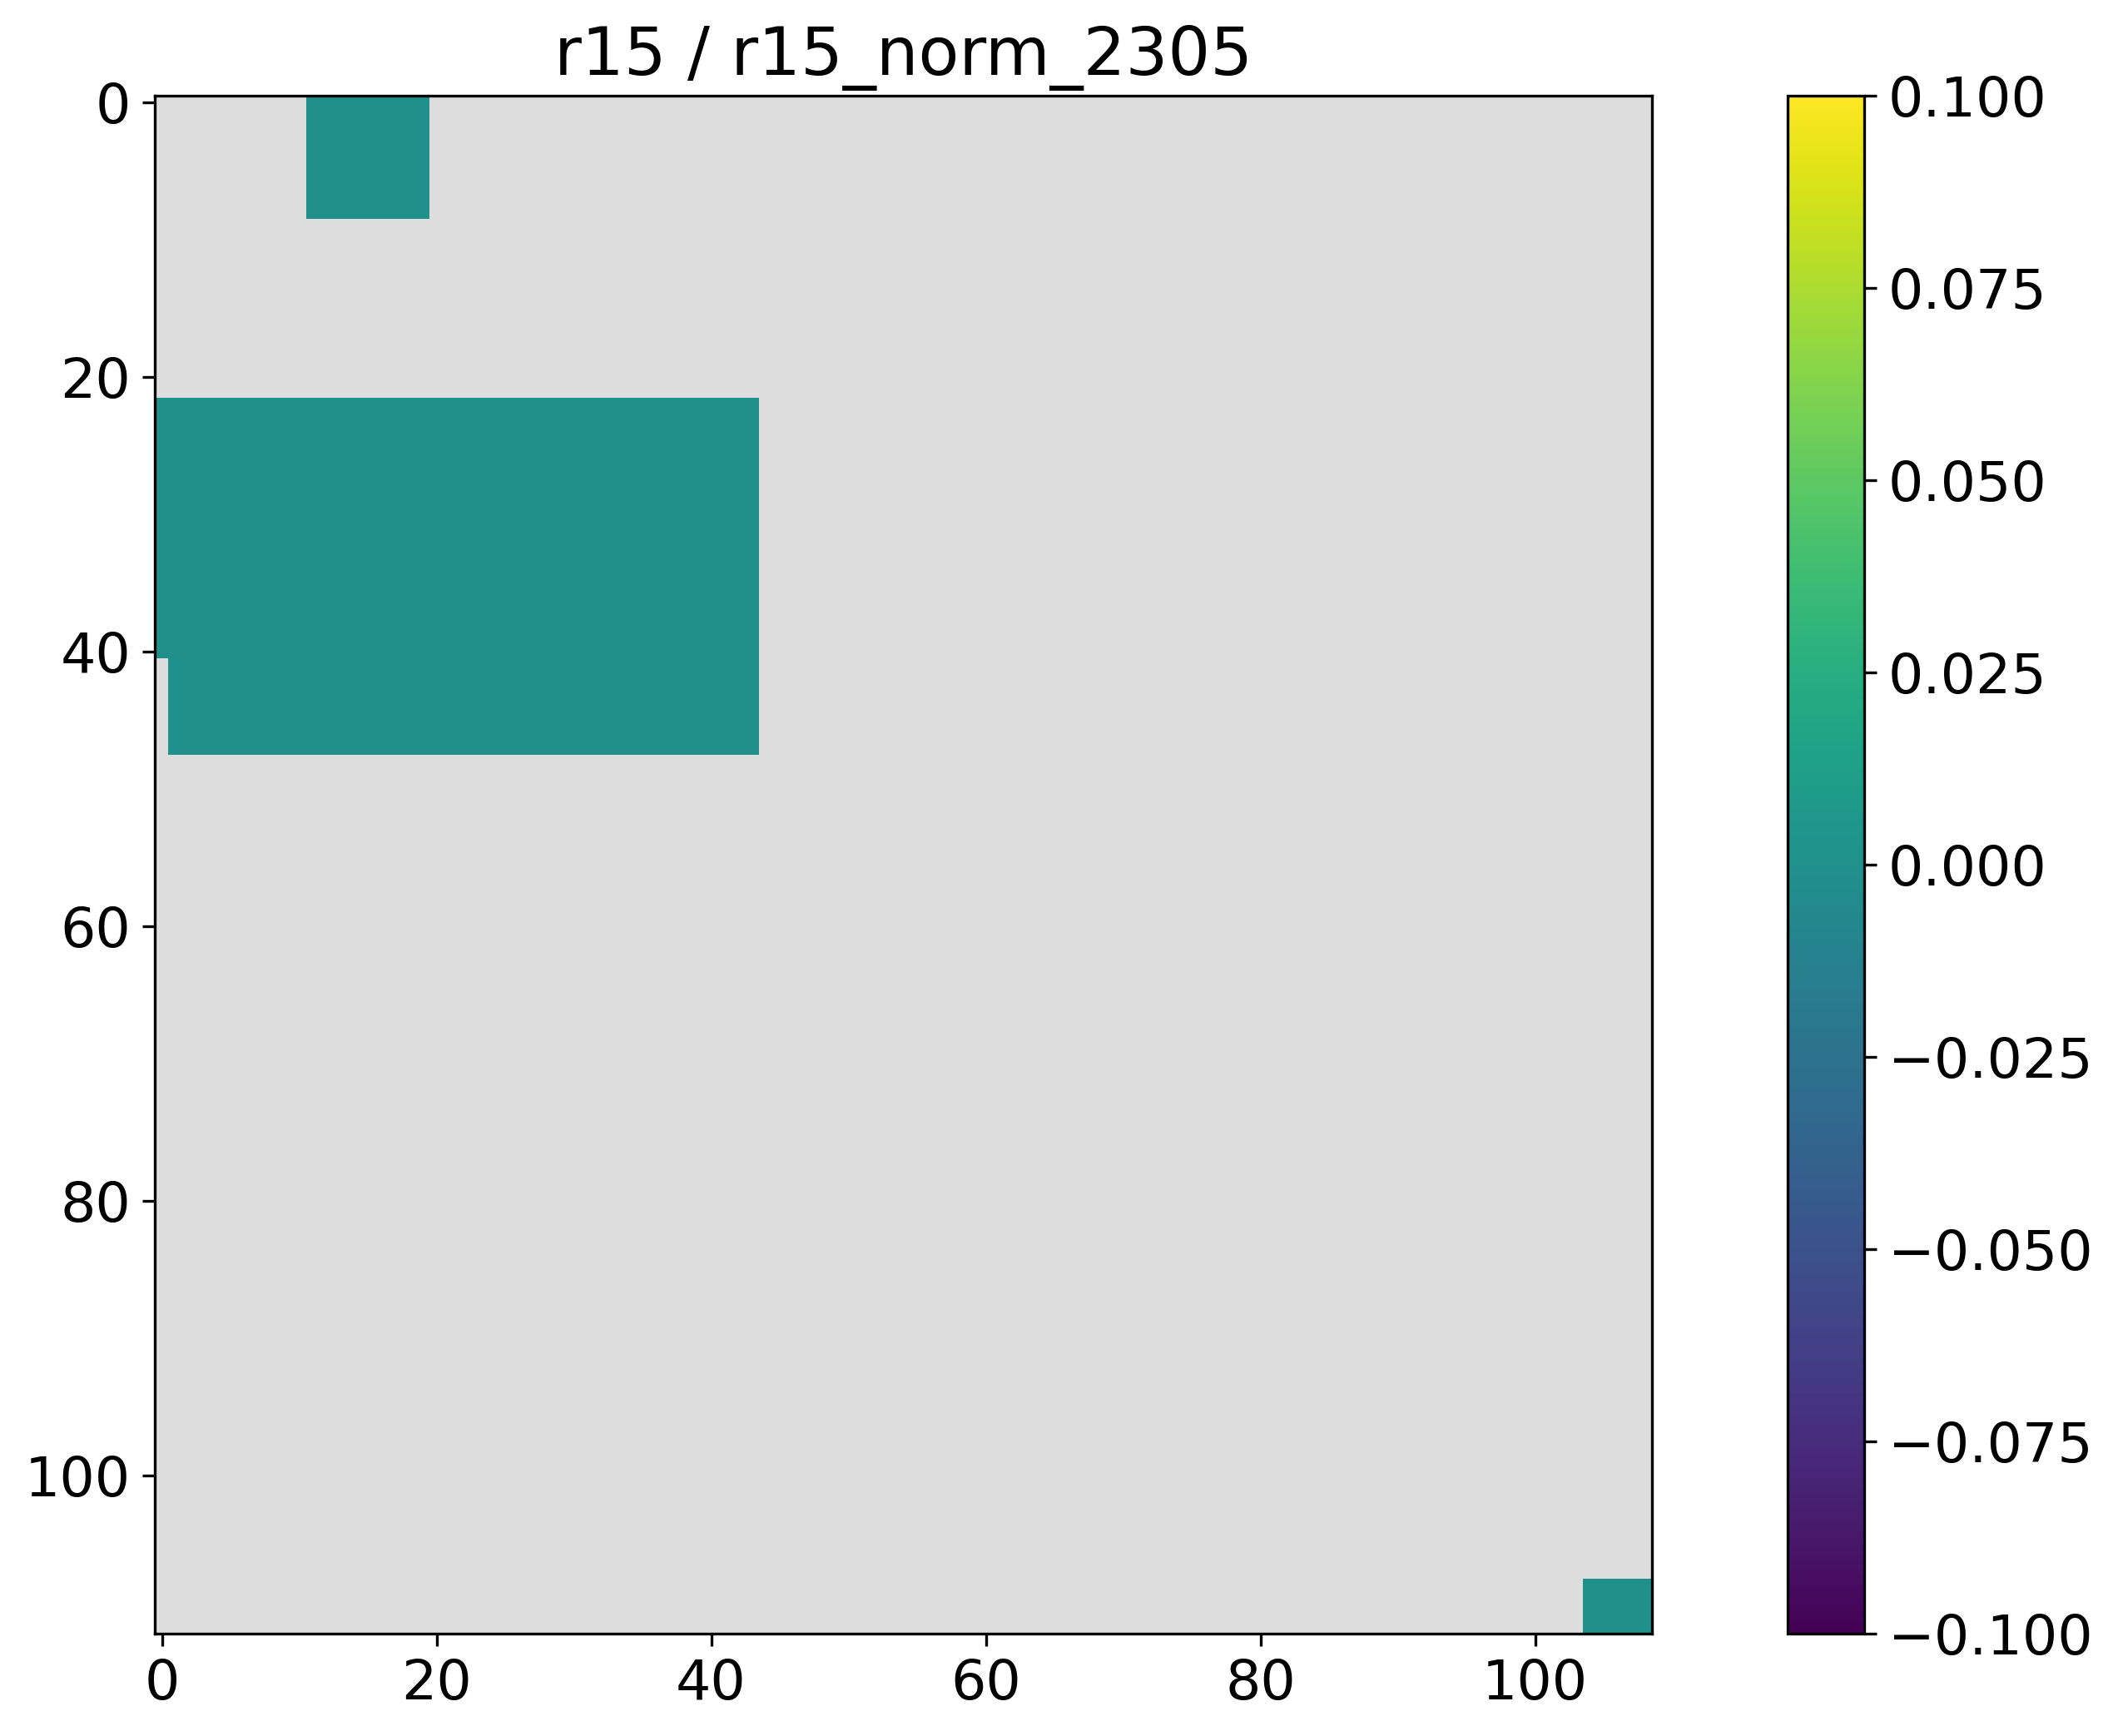

In [17]:
compare_lens("r15", r15, "r15_norm_2305", r15_norm_2305, figsize=(14,8))

### Centroiding method

In [18]:
from msi_zarr_analysis.preprocessing.centroiding import PickerKind, centroid_dict

ModuleNotFoundError: No module named 'pyopenms'

In [ ]:
tuple(PickerKind)

In [ ]:
def compare_centroiding_on_spectrum(s_mzs, s_int, *, axes: list, kinds) -> None:
    assert len(axes) == len(kinds) + 1, "must be one matplotlib axis for each kind, + no centroiding"
    
    lo, hi = 305, 330

    ax = axes[0]
    ax.stem(s_mzs, s_int, basefmt="none", markerfmt=",")
    ax.set_title(f"original ({s_mzs.size} pts.)")
    ax.set_xlim(lo, hi)
    
    for (ax, kind) in zip(axes[1:], kinds):
        centroided = centroid_dict({...: (s_mzs, s_int)}, kind)

        assert len(centroided) == 1, f"centroid_dict returned something weird: {centroided=!r}"
        c_mzs, c_int = list(centroided.values())[0]

        if c_mzs.size == 0:
            ax.set_title(kind.name + f": EMPTY RESULT")
            continue

        ax.stem(c_mzs, c_int, basefmt="none", markerfmt=",")
        ax.set_title(kind.name + f" ({c_mzs.size} pts.)")
        ax.set_xlim(lo, hi)

In [ ]:
def compare_centroiding_on_group(n_spectra: int, z_group, *, figsize, kinds=tuple(PickerKind)) -> None:
    n_len = z_group["/labels/lengths/0"][0, 0]
    idxs = np.nonzero(n_len)
    selection = np.random.randint(idxs[0].size, size=(n_spectra,))
    
    fig, axes = plt.subplots(
        nrows=len(kinds)+1,
        ncols=n_spectra,
        figsize=figsize,
        sharex=True,
        squeeze=False,
    )

    #lo, hi = 305, 330
    
    z_mzs = z_group["/labels/mzs/0"]
    z_int = z_group["/0"]
        
    for point_idx, (y, x) in enumerate(zip(idxs[0][selection], idxs[1][selection])):
        s_len = n_len[y, x]
        s_mzs = z_mzs[:s_len, 0, y, x]
        s_int = z_int[:s_len, 0, y, x]

        #sub_range = slice(
        #    np.searchsorted(s_mzs, lo, side="left"),
        #    np.searchsorted(s_mzs, hi, side="right"),
        #)
        
        compare_centroiding_on_spectrum(s_mzs, s_int, axes=axes[:, point_idx], kinds=kinds)
    
    fig.tight_layout()

In [ ]:
kinds = [
    PickerKind.PeakPickerHiRes,
    PickerKind.PeakPickerIterative,
    PickerKind.PeakPickerCWT,
    #--PickerKind.PeakPickerMaxima,  #-> needs 3 constructor arguments (double signal_to_noise, double spacing_difference, double sn_window_length) + take a third arg for pick
    #--PickerKind.PeakPickerMRM,  #-> specific to chromatogram
    #--PickerKind.PeakPickerSH,  #-> .pick() requires a third argument
]

In [ ]:
compare_centroiding_on_group(2, r13, figsize=(25, 24), kinds=kinds)

In [ ]:
compare_centroiding_on_group(2, r14, figsize=(25, 24), kinds=kinds)

In [ ]:
compare_centroiding_on_group(2, r15, figsize=(8, 7), kinds=kinds)

In [ ]:
compare_centroiding_on_group(2, r15_norm_2305, figsize=(25, 24), kinds=kinds)

### Compare m/z axis in region 14 and 15 (2305 vs original)

In [19]:
def check_same_mzs(z_group_left: zarr.Group, z_group_right: zarr.Group, print_: bool = False):
    n_len_left = z_group_left["/labels/lengths/0"][0, 0]
    n_len_right = z_group_right["/labels/lengths/0"][0, 0]

    count_same, count_diff = 0, 0
    
    z_mzs_left = z_group_left["/labels/mzs/0"]
    z_mzs_right = z_group_right["/labels/mzs/0"]
    
    for cy, cx in iter_loaded_chunks(z_mzs_left, skip=2):

        c_len = n_len_left[cy, cx]
        max_len = c_len.max()
        c_mzs_left = z_mzs_left[:max_len, 0, cy, cx]
        c_mzs_right = z_mzs_right[:max_len, 0, cy, cx]
        
        for y, x in zip(*np.nonzero(c_len)):

            if (c_mzs_left[:, y, x] == c_mzs_right[:, y, x]).all():
                count_same += 1
                if print_:
                    print(f"({cy.start + y}, {cx.start + x})")
            else:
                count_diff += 1
    
    return count_same, count_diff

In [20]:
check_same_mzs(r13, r13_norm_2305, print_=True)

(613, 398)


(1, 5426)

In [ ]:
check_same_mzs(r14, r14_norm_2305)

In [ ]:
check_same_mzs(r15, r15_norm_2305)

### Image ion at m/z = 317.176

In [21]:
def get_image_ion(dataset: zarr.Group, mz_val: float, mz_tol: float) -> np.ndarray:    
    z_int = dataset["/0"]
    z_mzs = dataset["/labels/mzs/0"]
    z_len = dataset["/labels/lengths/0"]
    
    n_len = z_len[0, 0]  # load all lengths
    bounds = autocrop(n_len)
    
    img = np.zeros(n_len.shape, dtype=z_int.dtype)
    
    for cy, cx in iter_loaded_chunks(z_int, *bounds, skip=2):
        c_len = n_len[cy, cx]
        max_len = c_len.max()

        c_int = z_int[:max_len, 0, cy, cx]
        c_mzs = z_mzs[:max_len, 0, cy, cx]
        
        for y, x in zip(*np.nonzero(c_len)):
            img_y = cy.start + y
            img_x = cx.start + x
            
            s_len = c_len[y, x]
            s_mzs = np.ascontiguousarray(c_mzs[:s_len, y, x])
            
            #idx = np.searchsorted(s_mzs, mz_val)
            #p_mzs = s_mzs[idx]
            #if p_mzs < mz_val - mz_tol or p_mzs > mz_val + mz_tol:
            #    continue
            #img[img_y, img_x] = c_int[idx, y, x]
            #continue

            lo = np.searchsorted(s_mzs, mz_val - mz_tol, side="left")
            hi = np.searchsorted(s_mzs, mz_val + mz_tol, side="right")
            
            range_int = c_int[lo:hi, y, x]
            
            #if range_int.size > 0:
            #    img[img_y, img_x] = range_int.mean()
            
            if range_int.size > 0:
                img[img_y, img_x] = range_int.sum()
    
    return img

In [22]:
def plot_ion_image(dataset: zarr.Group, mz_val: float, mz_tol: float, name: str, figsize: tuple):
    ion_image = get_image_ion(dataset, mz_val, mz_tol)
    
    lengths = dataset["/labels/lengths/0"][0, 0]
    bounds = autocrop(lengths)
    
    ion_image = np.where(lengths > 0, ion_image, np.nan)

    plt.figure(figsize=figsize)
    current_cmap = mpl.cm.get_cmap().copy()
    current_cmap.set_bad(color='black')

    plt.imshow(ion_image[bounds], interpolation="nearest", cmap=current_cmap)

    plt.title(name + f", at m/z = {mz_val} +- {mz_tol}")
    plt.colorbar()

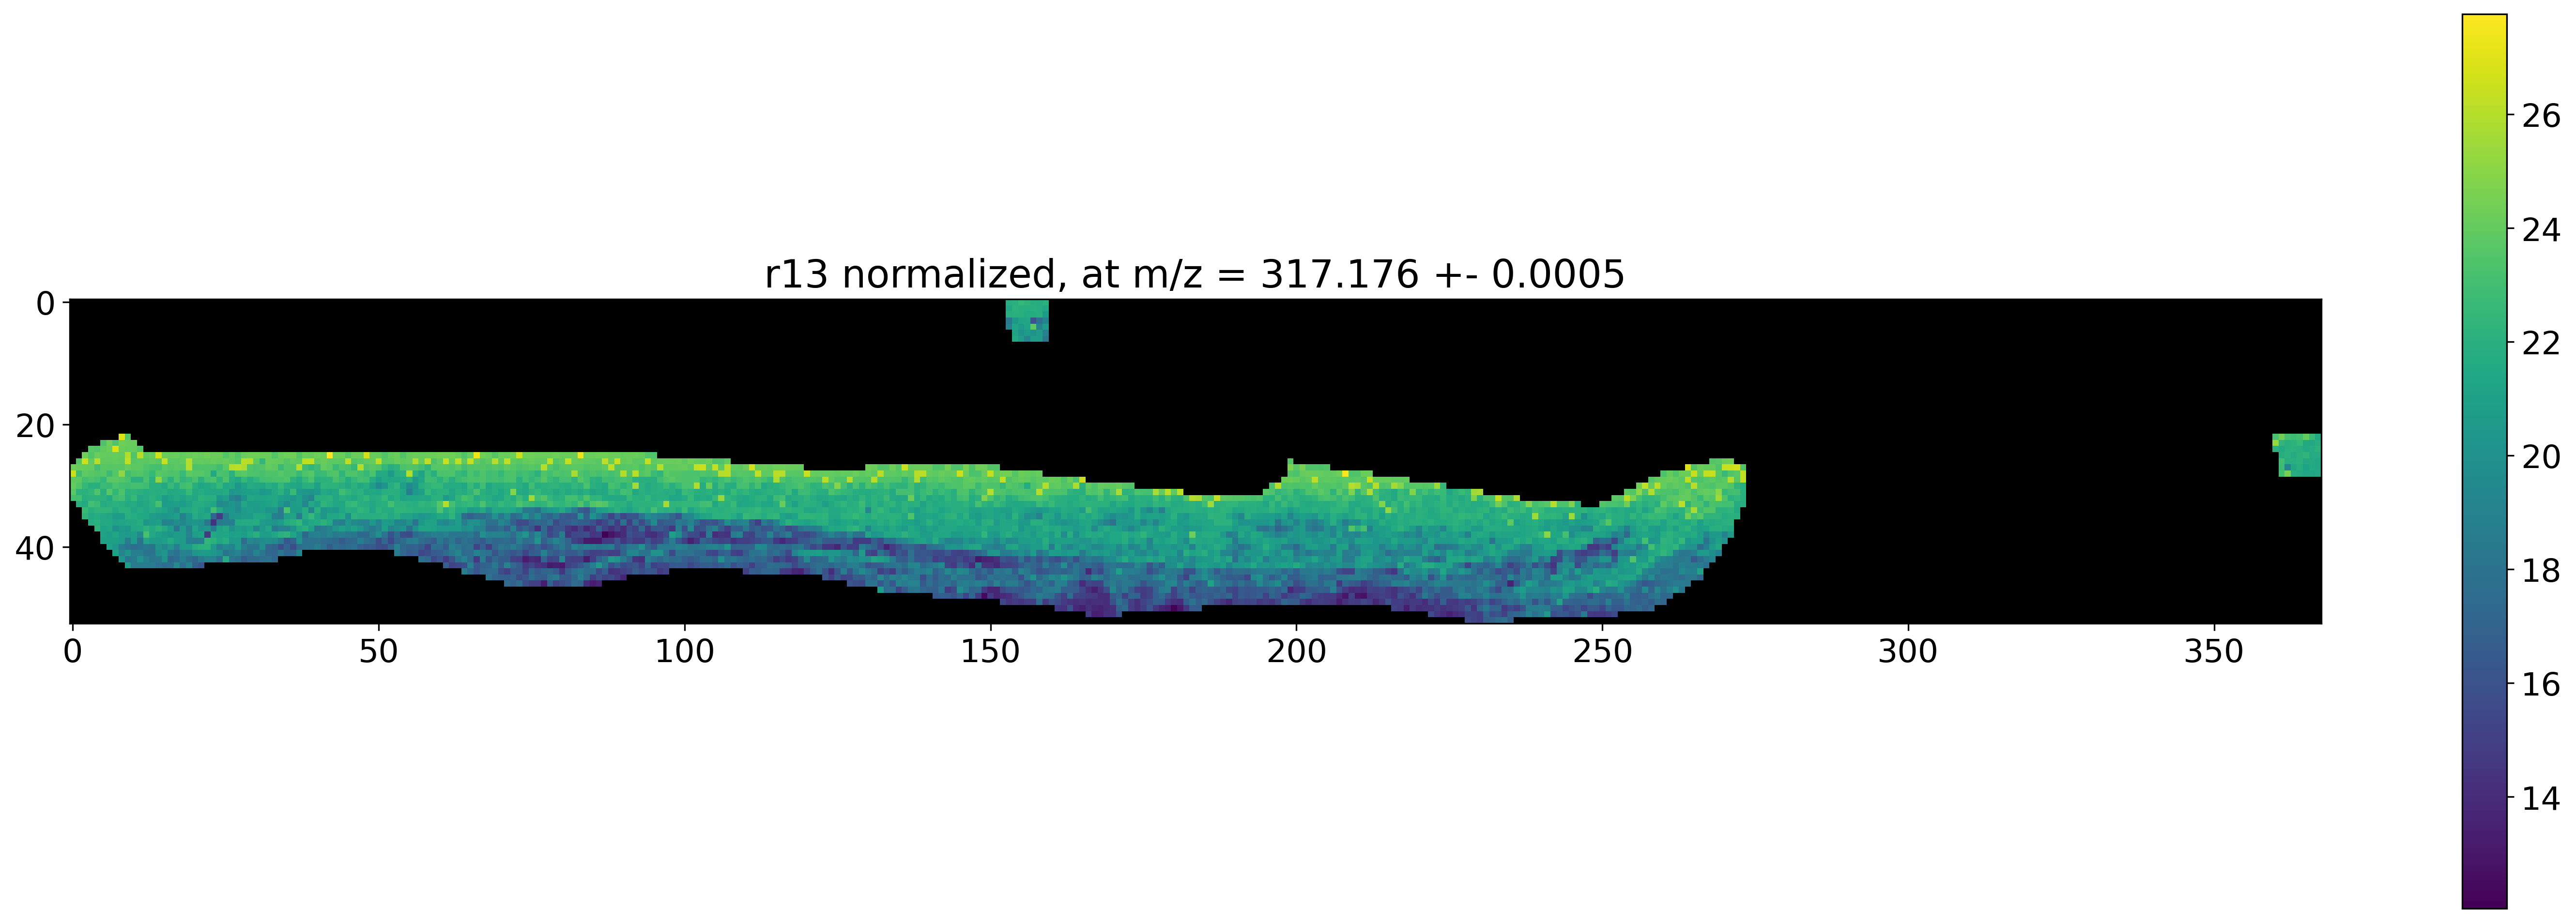

In [23]:
plot_ion_image(r13_norm_2305, 317.176, 5e-4, "r13 normalized", figsize=(25, 8))

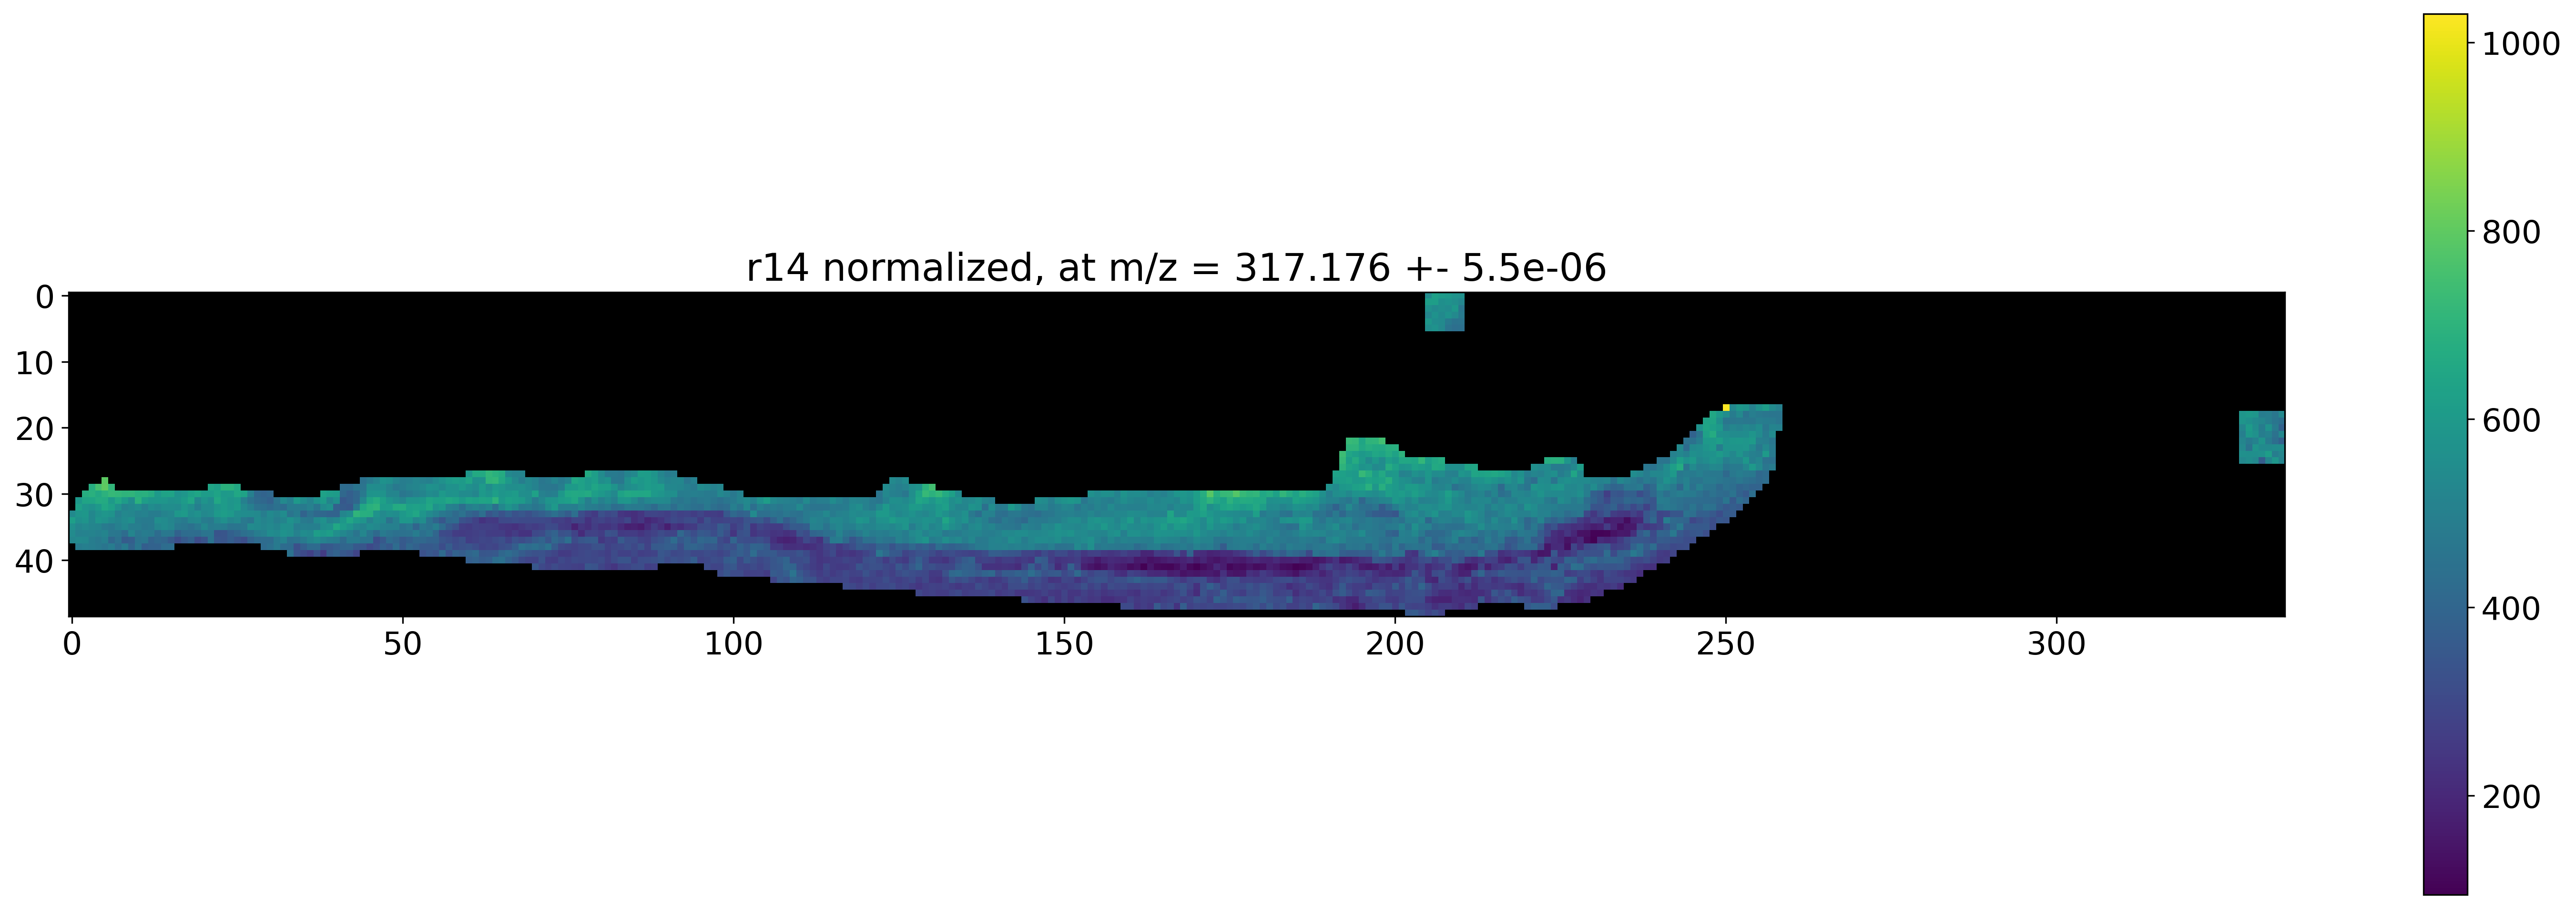

In [24]:
plot_ion_image(r14_norm_2305, 317.176, 5.5e-6, "r14 normalized", figsize=(25, 8))

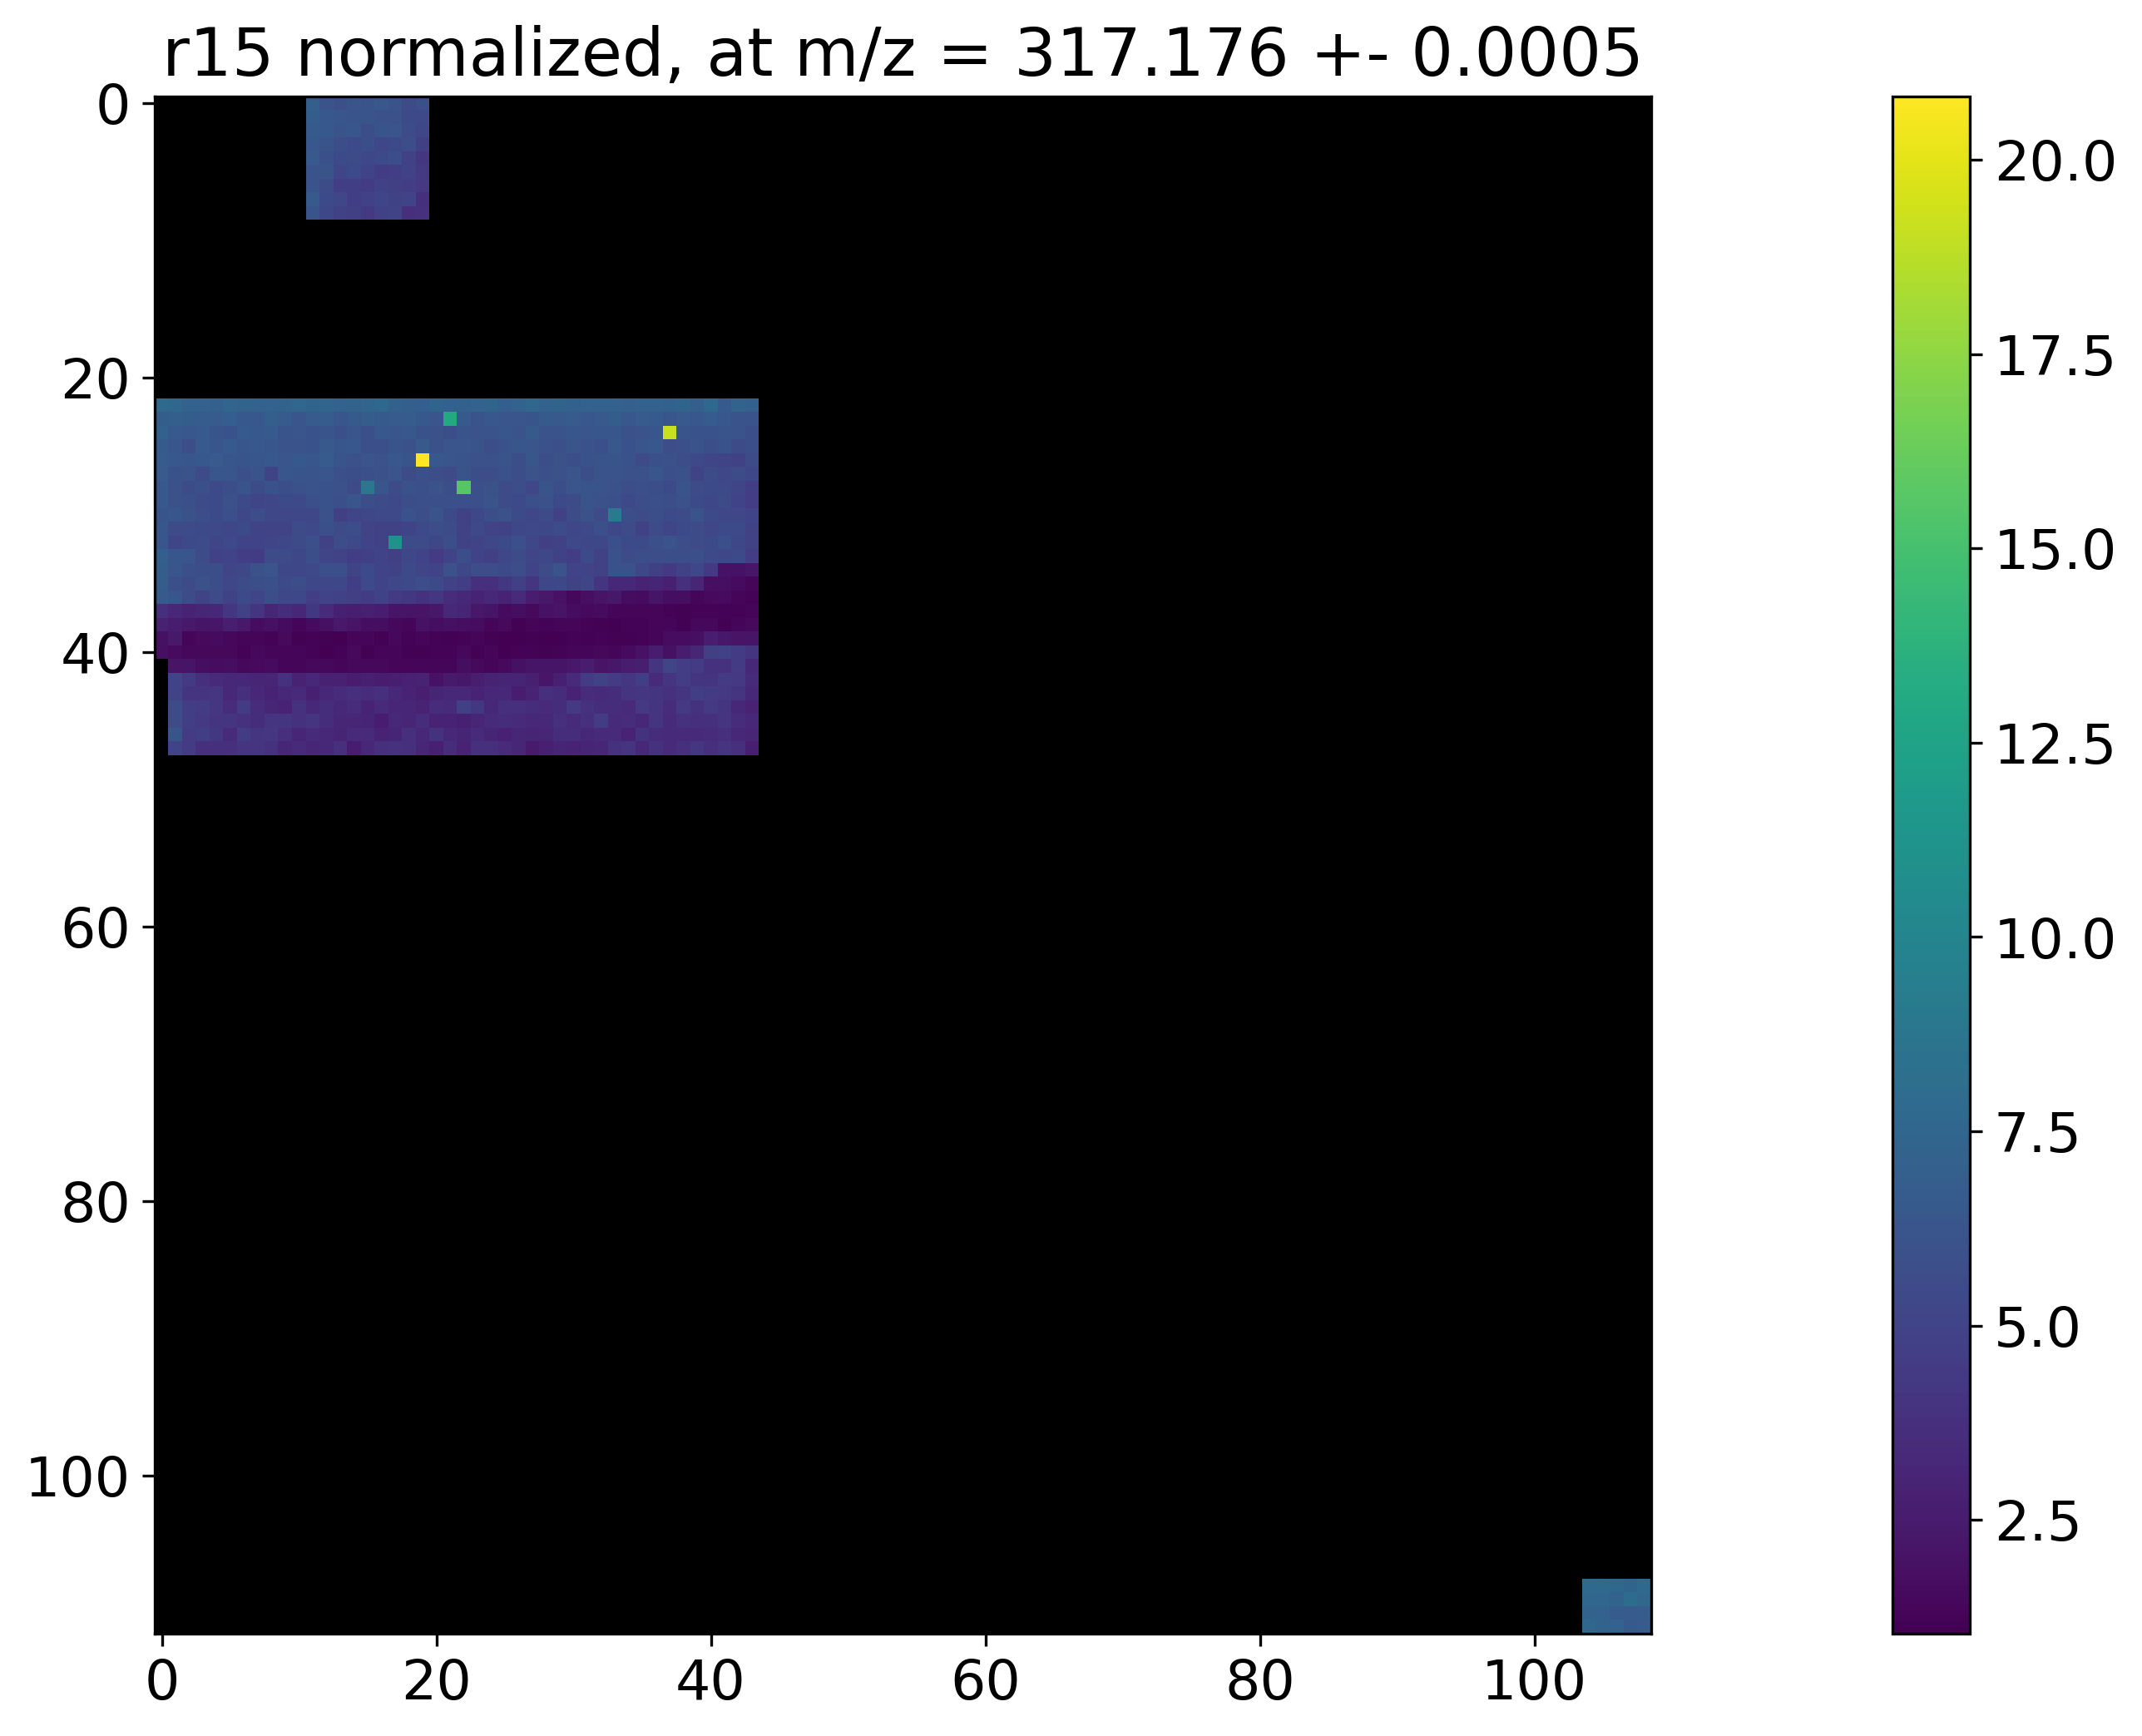

In [25]:
plot_ion_image(r15_norm_2305, 317.176, 5e-4, "r15 normalized", figsize=(25, 8))

### Sanity check the normalization (**region 14 and 15 only**)

In [ ]:
def sanity_check_normalization(dataset: zarr.Group, normalized: zarr.Group, n_spectra: int):
    n_len = dataset["/labels/lengths/0"][0, 0]
    idxs = np.nonzero(n_len)
    selection = np.random.randint(idxs[0].size, size=(n_spectra,))
    
    assert np.all(n_len == normalized["/labels/lengths/0"][0, 0]), "region 13 not usable"
    
    z_r_mzs = dataset["/labels/mzs/0"]
    z_n_mzs = normalized["/labels/mzs/0"]
    
    z_r_int = dataset["/0"]
    z_n_int = normalized["/0"]
    
    for y, x in zip(idxs[0][selection], idxs[1][selection]):
        s_len = n_len[y, x]
        s_mzs = z_r_mzs[:s_len, 0, y, x]
        
        s_r_int = z_r_int[:s_len, 0, y, x]
        s_n_int = z_n_int[:s_len, 0, y, x]
        
        ratio = s_r_int / s_n_int
        nan_per = np.isnan(ratio).sum() / ratio.size
        ratio = ratio[~np.isnan(ratio)]
        
        print(f"{y=} {x=:} {nan_per=:.5f} {ratio.mean()=:.2f} {ratio.std()=}")

In [ ]:
sanity_check_normalization(r15, r15_norm_2305, 5)

### Spacing between neighboring *m/z* values

In [ ]:
def plot_mz_diff(dataset: zarr.Group, *, n_spectra: int, name: str, figsize: tuple):
    n_len = dataset["/labels/lengths/0"][0, 0]
    idxs = np.nonzero(n_len)
    selection = np.random.randint(idxs[0].size, size=(n_spectra,))
    
    fig, axes = plt.subplots(
        #nrows=2,
        nrows=1,
        ncols=n_spectra,
        figsize=figsize,
        sharex=False,
        sharey=True,
        squeeze=False,
    )
    
    z_mzs = dataset["/labels/mzs/0"]
        
    for point_idx, (y, x) in enumerate(zip(idxs[0][selection], idxs[1][selection])):
        s_len = n_len[y, x]
        s_mzs = z_mzs[:s_len, 0, y, x]
        
        s_diff = np.diff(s_mzs)

        ax = axes[0, point_idx]
        ax.plot(s_mzs[:-1], s_diff)
        ax.set_ylabel("m/z spacing")
        ax.set_xlabel("m/z")
        ax.set_xlim(90, 1160)
        
        """
        ax = axes[1, point_idx]
        ax.plot(s_diff)
        ax.set_xlabel("idx")
        """
        
        ax.set_ylabel("m/z increase")
    fig.suptitle(f"Increase in m/z for {n_spectra} random spectra")
    
    fig.tight_layout()

In [ ]:
plot_mz_diff(r13, n_spectra=1, name="region13", figsize=(12, 7))

In [ ]:
plot_mz_diff(r14, n_spectra=2, name="region13", figsize=(25, 16))

In [ ]:
plot_mz_diff(r15, n_spectra=2, name="region13", figsize=(25, 16))

### Intersection of all spectra in a region

In [ ]:
def compute_intersection(dataset: zarr.Group):
    intersection = None
    
    n_len = dataset["/labels/lengths/0"][0, 0]
    z_mzs = dataset["/labels/mzs/0"]
    
    sum_sizes = 0
    n_sizes = 0
    
    for cy, cx in iter_loaded_chunks(z_mzs, skip=2):
        c_len = n_len[cy, cx]
        c_len_max = c_len.max()
        
        c_mzs = z_mzs[:c_len_max, 0, cy, cx]
        
        for y, x in zip(*np.nonzero(c_len)):
            s_mzs = c_mzs[:c_len[y, x], y, x]
            
            sum_sizes += s_mzs.size
            n_sizes += 1
            
            if intersection is None:
                intersection = s_mzs
                continue
            
            intersection = np.intersect1d(intersection, s_mzs)
    
    return intersection, sum_sizes / n_sizes

In [ ]:
intersection_r13, avg_size_r13 = compute_intersection(r13)

In [ ]:
intersection_r13_norm_2305, avg_size_r13_norm_2305 = compute_intersection(r13_norm_2305)

In [ ]:
intersection_r14, avg_size_r14 = compute_intersection(r14)

In [ ]:
intersection_r15, avg_size_r15 = compute_intersection(r15)

In [ ]:
intersection_glob = np.intersect1d(intersection_r13, np.intersect1d(intersection_r14, intersection_r15))

In [ ]:
intersection_glob.size

In [ ]:
intersection_r13.size, intersection_r14.size, intersection_r15.size